In [1]:
import os
import glob
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.acolite import (
    get_acolite_band_tif_paths,
    get_eopatch_for_acolite_band_tif
)

import optuna.integration.lightgbm as lgb
from lightgbm import (
    early_stopping,
    log_evaluation,
)
from sklearn.metrics import mean_squared_error

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_bahamas'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 10, 19, 15, 55, 31),
  'D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSIL2A_20211019T155531_N9999_R011_T17RQJ_20220423T204757.SAFE')]

In [3]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders

['D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSI_20211019T155531_ACOLITE_SUBSET']

In [4]:
bathy_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_bathy_eop')
)
load_bathy_eop = LoadTask(bathy_eop_path)

output_label = 'bahamas_bathy_eop'

wf_nodes = linearly_connect_tasks(
    load_bathy_eop,
    OutputTask(output_label),
)
workflow = EOWorkflow(wf_nodes)

workflow_result = workflow.execute()
bahamas_bathy_eop = workflow_result.outputs[output_label]

height, width, _ = bahamas_bathy_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=bahamas_bathy_eop.bbox)

acolite_product = 'L2W'
acolite_band_tifs = get_acolite_band_tif_paths(sentinel_acolite_folders[0], product_type=acolite_product, reflectance_type='rhow')
acolite_image_bands = [get_eopatch_for_acolite_band_tif(os.path.abspath(x), bahamas_bathy_eop.bbox, (FeatureType.DATA, f'{acolite_product}_data')) for x in acolite_band_tifs]

merge_acolite_bands = MergeEOPatchesTask()
acolite_image = merge_acolite_bands.execute(*acolite_image_bands)

merge_band_data = eolearn.core.MergeFeatureTask(
    [(FeatureType.DATA, x) for x in sorted(acolite_image.get_features()[(FeatureType.DATA)], key=lambda x: int(x.split('_')[-1]))],
    (FeatureType.DATA, f'{acolite_product}_data')
)
merge_band_data.execute(acolite_image)

merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(bahamas_bathy_eop, l2a_eopatch, acolite_image)

In [5]:
data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

input_task = InputTask(merged_eop)
input_node = EONode(input_task, inputs=tuple())

train_test_split_node = EONode(train_test_split_task, inputs=[input_node])
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

train_test_wf = EOWorkflow(
    [
        input_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node
    ]
)

tt_wf_res = train_test_wf.execute(
    input_kwargs={
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = tt_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 894, 1946, 12), dtype=uint16)
    L2W_data: numpy.ndarray(shape=(1, 894, 1946, 11), dtype=float32)
    L2W_data_rhow_1614: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_2202: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_443: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_492: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_560: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_665: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_704: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_740: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_783: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_833: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float32)
    L2W_data_rhow_865: numpy.ndarray(shape=(1, 894, 1946, 1), dtype=float

In [6]:
train_test_eop.meta_info

{'mission': 'S2A',
 'train_count': 43427,
 'test_count': 1653194,
 'validation_count': 43103,
 'train_perc': 0.02496200546753393,
 'test_perc': 0.950262225502436,
 'validation_perc': 0.02477576903003005}

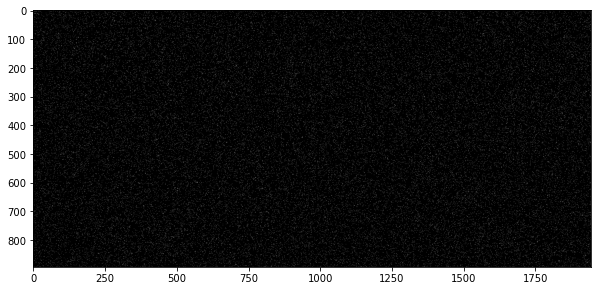

In [9]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

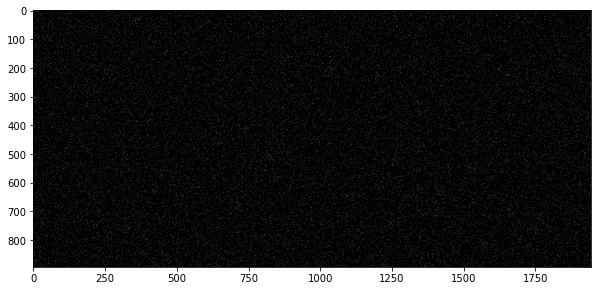

In [10]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'validation_split_valid'), colorbar=False, stretch=False)
plt.show()

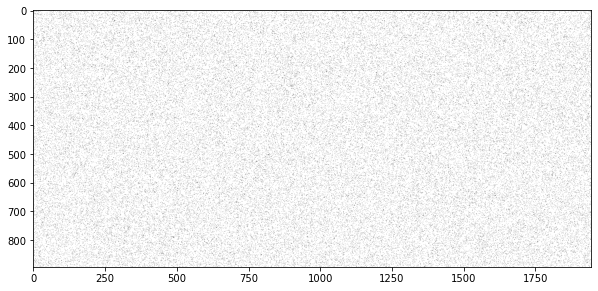

In [11]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False, stretch=False)
plt.show()

In [12]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=12, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_train_index == 1], (train_test_eop.meta_info['train_count'], 12))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
train_ds = lgb.Dataset(X, label=y)
X.shape, y.shape

((43427, 12), (43427,))

In [13]:
all_band_val_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'validation_split_valid')], repeats=12, axis=-1)
X_val = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_val_index == 1], (train_test_eop.meta_info['validation_count'], 12))
y_val = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'validation_split_valid')] == 1]
val_ds = lgb.Dataset(X_val, label=y_val)
X_val.shape, y_val.shape

((43103, 12), (43103,))

In [14]:
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'boosting_type': 'dart',
    'num_boost_round': 100,
    'force_col_wise': True,
}

model = lgb.train(
    params,
    train_ds,
    valid_sets=[train_ds, val_ds],
    # callbacks=[log_evaluation(100)],
)

[I 2022-04-27 17:41:39,088] A new study created in memory with name: no-name-5343db6b-1929-4126-a3f0-685503b25a30
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.898567	valid_1's l2: 0.902017
[2]	valid_0's l2: 0.732774	valid_1's l2: 0.735634
[3]	valid_0's l2: 0.614906	valid_1's l2: 0.617163
[4]	valid_0's l2: 0.509643	valid_1's l2: 0.511382
[5]	valid_0's l2: 0.418066	valid_1's l2: 0.419542
[6]	valid_0's l2: 0.343534	valid_1's l2: 0.344802
[7]	valid_0's l2: 0.287518	valid_1's l2: 0.288551
[8]	valid_0's l2: 0.31912	valid_1's l2: 0.320273
[9]	valid_0's l2: 0.263239	valid_1's l2: 0.264304
[10]	valid_0's l2: 0.217919	valid_1's l2: 0.218891
[11]	valid_0's l2: 0.181114	valid_1's l2: 0.182026
[12]	valid_0's l2: 0.198233	valid_1's l2: 0.199195
[13]	valid_0's l2: 0.165428	valid_1's l2: 0.166266
[14]	valid_0's l2: 0.142796	valid_1's l2: 0.143554
[15]	valid_0's l2: 0.124483	valid_1's l2: 0.125185
[16]	valid_0's l2: 0.105191	valid_1's l2: 0.105913
[17]	valid_0's

feature_fraction, val_score: 0.124024:  14%|#4        | 1/7 [00:00<00:04,  1.22it/s]

[84]	valid_0's l2: 0.094913	valid_1's l2: 0.0964586
[85]	valid_0's l2: 0.102602	valid_1's l2: 0.104157
[86]	valid_0's l2: 0.0862138	valid_1's l2: 0.0877449
[87]	valid_0's l2: 0.0730841	valid_1's l2: 0.0745861
[88]	valid_0's l2: 0.0786807	valid_1's l2: 0.0801841
[89]	valid_0's l2: 0.0799253	valid_1's l2: 0.0814088
[90]	valid_0's l2: 0.0855099	valid_1's l2: 0.0869983
[91]	valid_0's l2: 0.267459	valid_1's l2: 0.269272
[92]	valid_0's l2: 0.219914	valid_1's l2: 0.22169
[93]	valid_0's l2: 0.181681	valid_1's l2: 0.183422
[94]	valid_0's l2: 0.196504	valid_1's l2: 0.198258
[95]	valid_0's l2: 0.200903	valid_1's l2: 0.202656
[96]	valid_0's l2: 0.209228	valid_1's l2: 0.210979
[97]	valid_0's l2: 0.1727	valid_1's l2: 0.174398
[98]	valid_0's l2: 0.178071	valid_1's l2: 0.179765
[99]	valid_0's l2: 0.147262	valid_1's l2: 0.148887
[100]	valid_0's l2: 0.122454	valid_1's l2: 0.124024


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.88167	valid_1's l2: 0.885193
[2]	valid_0's l2: 0.71894	valid_1's l2: 0.721902
[3]	valid_0's l2: 0.586929	valid_1's l2: 0.589449
[4]	valid_0's l2: 0.47984	valid_1's l2: 0.482085
[5]	valid_0's l2: 0.393019	valid_1's l2: 0.394929
[6]	valid_0's l2: 0.322631	valid_1's l2: 0.324281
[7]	valid_0's l2: 0.265528	valid_1's l2: 0.266987
[8]	valid_0's l2: 0.295566	valid_1's l2: 0.297145
[9]	valid_0's l2: 0.243473	valid_1's l2: 0.244871
[10]	valid_0's l2: 0.201212	valid_1's l2: 0.202437
[11]	valid_0's l2: 0.166919	valid_1's l2: 0.168026
[12]	valid_0's l2: 0.182833	valid_1's l2: 0.184001
[13]	valid_0's l2: 0.152026	valid_1's l2: 0.153088
[14]	valid_0's l2: 0.127726	valid_1's l2: 0.128658
[15]	valid_0's l2: 0.107201	valid_1's l2: 0.108047
[16]	valid_0's l2: 0.0905142	valid_1's l2: 0.0913215
[17]	valid_0's

feature_fraction, val_score: 0.121281:  29%|##8       | 2/7 [00:01<00:04,  1.20it/s]

[89]	valid_0's l2: 0.0769589	valid_1's l2: 0.078168
[90]	valid_0's l2: 0.0825274	valid_1's l2: 0.0837436
[91]	valid_0's l2: 0.264649	valid_1's l2: 0.266148
[92]	valid_0's l2: 0.217195	valid_1's l2: 0.218655
[93]	valid_0's l2: 0.178757	valid_1's l2: 0.180195
[94]	valid_0's l2: 0.19361	valid_1's l2: 0.195063
[95]	valid_0's l2: 0.197888	valid_1's l2: 0.199339
[96]	valid_0's l2: 0.206256	valid_1's l2: 0.207707
[97]	valid_0's l2: 0.169877	valid_1's l2: 0.171254
[98]	valid_0's l2: 0.175268	valid_1's l2: 0.176645
[99]	valid_0's l2: 0.144743	valid_1's l2: 0.146078
[100]	valid_0's l2: 0.119997	valid_1's l2: 0.121281


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.881597	valid_1's l2: 0.885136
[2]	valid_0's l2: 0.718872	valid_1's l2: 0.72187
[3]	valid_0's l2: 0.586833	valid_1's l2: 0.589454
[4]	valid_0's l2: 0.479739	valid_1's l2: 0.482095
[5]	valid_0's l2: 0.392927	valid_1's l2: 0.394951
[6]	valid_0's l2: 0.322505	valid_1's l2: 0.3243
[7]	valid_0's l2: 0.265367	valid_1's l2: 0.266926
[8]	valid_0's l2: 0.295412	valid_1's l2: 0.297067
[9]	valid_0's l2: 0.243312	valid_1's l2: 0.244772
[10]	valid_0's l2: 0.201074	valid_1's l2: 0.202361
[11]	valid_0's l2: 0.166782	valid_1's l2: 0.167964
[12]	valid_0's l2: 0.182703	valid_1's l2: 0.183937
[13]	valid_0's l2: 0.151875	valid_1's l2: 0.153018
[14]	valid_0's l2: 0.126992	valid_1's l2: 0.128048
[15]	valid_0's l2: 0.106551	valid_1's l2: 0.107512
[16]	valid_0's l2: 0.089919	valid_1's l2: 0.0908369
[17]	valid_0's 

feature_fraction, val_score: 0.121205:  43%|####2     | 3/7 [00:02<00:03,  1.09it/s]

[91]	valid_0's l2: 0.264494	valid_1's l2: 0.265972
[92]	valid_0's l2: 0.217052	valid_1's l2: 0.2185
[93]	valid_0's l2: 0.178587	valid_1's l2: 0.179998
[94]	valid_0's l2: 0.193434	valid_1's l2: 0.194858
[95]	valid_0's l2: 0.197709	valid_1's l2: 0.199133
[96]	valid_0's l2: 0.206086	valid_1's l2: 0.207518
[97]	valid_0's l2: 0.169715	valid_1's l2: 0.171105
[98]	valid_0's l2: 0.175102	valid_1's l2: 0.176492
[99]	valid_0's l2: 0.144603	valid_1's l2: 0.14595
[100]	valid_0's l2: 0.119882	valid_1's l2: 0.121205


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.881675	valid_1's l2: 0.885211
[2]	valid_0's l2: 0.718954	valid_1's l2: 0.72192
[3]	valid_0's l2: 0.587623	valid_1's l2: 0.590172
[4]	valid_0's l2: 0.481537	valid_1's l2: 0.483718
[5]	valid_0's l2: 0.394361	valid_1's l2: 0.396235
[6]	valid_0's l2: 0.32375	valid_1's l2: 0.325384
[7]	valid_0's l2: 0.268936	valid_1's l2: 0.270292
[8]	valid_0's l2: 0.29906	valid_1's l2: 0.300518
[9]	valid_0's l2: 0.246503	valid_1's l2: 0.247782
[10]	valid_0's l2: 0.203822	valid_1's l2: 0.204925
[11]	valid_0's l2: 0.16917	valid_1's l2: 0.170155
[12]	valid_0's l2: 0.185363	valid_1's l2: 0.186413
[13]	valid_0's l2: 0.154288	valid_1's l2: 0.155241
[14]	valid_0's l2: 0.131458	valid_1's l2: 0.132282
[15]	valid_0's l2: 0.111774	valid_1's l2: 0.112496
[16]	valid_0's l2: 0.0943849	valid_1's l2: 0.0950941
[17]	valid_0's 

feature_fraction, val_score: 0.121205:  57%|#####7    | 4/7 [00:03<00:02,  1.08it/s]

[95]	valid_0's l2: 0.199115	valid_1's l2: 0.200551
[96]	valid_0's l2: 0.207462	valid_1's l2: 0.208896
[97]	valid_0's l2: 0.17105	valid_1's l2: 0.172455
[98]	valid_0's l2: 0.176443	valid_1's l2: 0.177842
[99]	valid_0's l2: 0.145787	valid_1's l2: 0.14717
[100]	valid_0's l2: 0.120969	valid_1's l2: 0.122312
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.899187	valid_1's l2: 0.902483
[2]	valid_0's l2: 0.734552	valid_1's l2: 0.737213
[3]	valid_0's l2: 0.60427	valid_1's l2: 0.606212
[4]	valid_0's l2: 0.494634	valid_1's l2: 0.496351
[5]	valid_0's l2: 0.406241	valid_1's l2: 0.407782
[6]	valid_0's l2: 0.333874	valid_1's l2: 0.335229
[7]	valid_0's l2: 0.275605	valid_1's l2: 0.276801
[8]	valid_0's l2: 0.308953	valid_1's l2: 0.310246
[9]	valid_0's l2: 0.261613	valid_1's l2: 0.262675
[10]	valid_0's l2: 0.224033	valid_1's l2: 0.224958
[11]	valid_0's 

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[22]	valid_0's l2: 0.0569888	valid_1's l2: 0.0577519
[23]	valid_0's l2: 0.0502752	valid_1's l2: 0.0510287
[24]	valid_0's l2: 0.0445008	valid_1's l2: 0.0452758
[25]	valid_0's l2: 0.0401901	valid_1's l2: 0.0409934
[26]	valid_0's l2: 0.0361776	valid_1's l2: 0.0370028
[27]	valid_0's l2: 0.0329843	valid_1's l2: 0.0338579
[28]	valid_0's l2: 0.0353687	valid_1's l2: 0.0362369
[29]	valid_0's l2: 0.032333	valid_1's l2: 0.0332085
[30]	valid_0's l2: 0.0296732	valid_1's l2: 0.0305587
[31]	valid_0's l2: 0.0307039	valid_1's l2: 0.031582
[32]	valid_0's l2: 0.0287899	valid_1's l2: 0.0296795
[33]	valid_0's l2: 0.027197	valid_1's l2: 0.0280924
[34]	valid_0's l2: 0.0261912	valid_1's l2: 0.0271034
[35]	valid_0's l2: 0.0280293	valid_1's l2: 0.0289346
[36]	valid_0's l2: 0.0328829	valid_1's l2: 0.0337846
[37]	valid_0's l2: 0.0301179	valid_1's l2: 0.0310455
[38]	valid_0's l2: 0.0278029	valid_1's l2: 0.028756
[39]	valid_0's l2: 0.0260558	valid_1's l2: 0.0270381
[40]	valid_0's l2: 0.0267841	valid_1's l2: 0.02777

feature_fraction, val_score: 0.121205:  71%|#######1  | 5/7 [00:04<00:01,  1.12it/s]

[92]	valid_0's l2: 0.221309	valid_1's l2: 0.223204
[93]	valid_0's l2: 0.182607	valid_1's l2: 0.184453
[94]	valid_0's l2: 0.197522	valid_1's l2: 0.199393
[95]	valid_0's l2: 0.201946	valid_1's l2: 0.203821
[96]	valid_0's l2: 0.210444	valid_1's l2: 0.212324
[97]	valid_0's l2: 0.17374	valid_1's l2: 0.175555
[98]	valid_0's l2: 0.17925	valid_1's l2: 0.181063
[99]	valid_0's l2: 0.148847	valid_1's l2: 0.150595
[100]	valid_0's l2: 0.124224	valid_1's l2: 0.125934
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880898	valid_1's l2: 0.884375
[2]	valid_0's l2: 0.718212	valid_1's l2: 0.721186
[3]	valid_0's l2: 0.586367	valid_1's l2: 0.588847
[4]	valid_0's l2: 0.479438	valid_1's l2: 0.481523
[5]	valid_0's l2: 0.392647	valid_1's l2: 0.394454


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	valid_0's l2: 0.3223	valid_1's l2: 0.323908
[7]	valid_0's l2: 0.265248	valid_1's l2: 0.266668
[8]	valid_0's l2: 0.295289	valid_1's l2: 0.2968
[9]	valid_0's l2: 0.243281	valid_1's l2: 0.244619
[10]	valid_0's l2: 0.201003	valid_1's l2: 0.202168
[11]	valid_0's l2: 0.166683	valid_1's l2: 0.167717
[12]	valid_0's l2: 0.182617	valid_1's l2: 0.183699
[13]	valid_0's l2: 0.151798	valid_1's l2: 0.152767
[14]	valid_0's l2: 0.126727	valid_1's l2: 0.127628
[15]	valid_0's l2: 0.106322	valid_1's l2: 0.107165
[16]	valid_0's l2: 0.089768	valid_1's l2: 0.0905702
[17]	valid_0's l2: 0.0762833	valid_1's l2: 0.077036
[18]	valid_0's l2: 0.0652808	valid_1's l2: 0.066021
[19]	valid_0's l2: 0.0562906	valid_1's l2: 0.0570126
[20]	valid_0's l2: 0.0489793	valid_1's l2: 0.0496831
[21]	valid_0's l2: 0.0539074	valid_1's l2: 0.0546159
[22]	valid_0's l2: 0.0469827	valid_1's l2: 0.0477007
[23]	valid_0's l2: 0.0413088	valid_1's l2: 0.0420429
[24]	valid_0's l2: 0.036686	valid_1's l2: 0.0374067
[25]	valid_0's l2: 0.0328

feature_fraction, val_score: 0.121205:  86%|########5 | 6/7 [00:05<00:00,  1.11it/s]

[96]	valid_0's l2: 0.206071	valid_1's l2: 0.207543
[97]	valid_0's l2: 0.16971	valid_1's l2: 0.171133
[98]	valid_0's l2: 0.175087	valid_1's l2: 0.176516
[99]	valid_0's l2: 0.144612	valid_1's l2: 0.146019
[100]	valid_0's l2: 0.119897	valid_1's l2: 0.121251
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.881671	valid_1's l2: 0.885191
[2]	valid_0's l2: 0.718948	valid_1's l2: 0.721917
[3]	valid_0's l2: 0.586991	valid_1's l2: 0.589534
[4]	valid_0's l2: 0.480988	valid_1's l2: 0.483153
[5]	valid_0's l2: 0.393898	valid_1's l2: 0.395774
[6]	valid_0's l2: 0.323376	valid_1's l2: 0.324987
[7]	valid_0's l2: 0.267886	valid_1's l2: 0.269229
[8]	valid_0's l2: 0.297984	valid_1's l2: 0.299434
[9]	valid_0's l2: 0.245548	valid_1's l2: 0.246803
[10]	valid_0's l2: 0.202939	valid_1's l2: 0.204084
[11]	valid_0's l2: 0.168411	valid_1's l2: 0.169419
[12]	valid_0'

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[17]	valid_0's l2: 0.0802045	valid_1's l2: 0.0808873
[18]	valid_0's l2: 0.0686271	valid_1's l2: 0.0692997
[19]	valid_0's l2: 0.059109	valid_1's l2: 0.0597851
[20]	valid_0's l2: 0.0513897	valid_1's l2: 0.0520712
[21]	valid_0's l2: 0.0564436	valid_1's l2: 0.0571259
[22]	valid_0's l2: 0.0492687	valid_1's l2: 0.0499563
[23]	valid_0's l2: 0.0433298	valid_1's l2: 0.0440366
[24]	valid_0's l2: 0.0384248	valid_1's l2: 0.0391438
[25]	valid_0's l2: 0.0344403	valid_1's l2: 0.035187
[26]	valid_0's l2: 0.0312726	valid_1's l2: 0.03205
[27]	valid_0's l2: 0.0289728	valid_1's l2: 0.0297575
[28]	valid_0's l2: 0.0310239	valid_1's l2: 0.0318014
[29]	valid_0's l2: 0.0283916	valid_1's l2: 0.0291866
[30]	valid_0's l2: 0.0262497	valid_1's l2: 0.0270815
[31]	valid_0's l2: 0.0279674	valid_1's l2: 0.0287957
[32]	valid_0's l2: 0.0258681	valid_1's l2: 0.0267113
[33]	valid_0's l2: 0.0240853	valid_1's l2: 0.0249458
[34]	valid_0's l2: 0.022584	valid_1's l2: 0.0234509
[35]	valid_0's l2: 0.0241817	valid_1's l2: 0.025042

feature_fraction, val_score: 0.121205: 100%|##########| 7/7 [00:06<00:00,  1.11it/s]


[99]	valid_0's l2: 0.145303	valid_1's l2: 0.14666
[100]	valid_0's l2: 0.120538	valid_1's l2: 0.121857


num_leaves, val_score: 0.121205:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880116	valid_1's l2: 0.883748
[2]	valid_0's l2: 0.716311	valid_1's l2: 0.719491
[3]	valid_0's l2: 0.583509	valid_1's l2: 0.58628
[4]	valid_0's l2: 0.475862	valid_1's l2: 0.478351
[5]	valid_0's l2: 0.388531	valid_1's l2: 0.390731
[6]	valid_0's l2: 0.317723	valid_1's l2: 0.319733
[7]	valid_0's l2: 0.260292	valid_1's l2: 0.262215
[8]	valid_0's l2: 0.290553	valid_1's l2: 0.292544
[9]	valid_0's l2: 0.238224	valid_1's l2: 0.240056


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 0.195854	valid_1's l2: 0.197583
[11]	valid_0's l2: 0.161407	valid_1's l2: 0.163063
[12]	valid_0's l2: 0.177404	valid_1's l2: 0.179105
[13]	valid_0's l2: 0.146508	valid_1's l2: 0.148159
[14]	valid_0's l2: 0.121401	valid_1's l2: 0.123025
[15]	valid_0's l2: 0.100927	valid_1's l2: 0.102559
[16]	valid_0's l2: 0.0843144	valid_1's l2: 0.0859401
[17]	valid_0's l2: 0.0707819	valid_1's l2: 0.072408
[18]	valid_0's l2: 0.0598324	valid_1's l2: 0.0614836
[19]	valid_0's l2: 0.050894	valid_1's l2: 0.0525726
[20]	valid_0's l2: 0.0436181	valid_1's l2: 0.0453334
[21]	valid_0's l2: 0.0485612	valid_1's l2: 0.0502789
[22]	valid_0's l2: 0.0417416	valid_1's l2: 0.043496
[23]	valid_0's l2: 0.0361627	valid_1's l2: 0.0379656
[24]	valid_0's l2: 0.0315732	valid_1's l2: 0.0334038
[25]	valid_0's l2: 0.0278456	valid_1's l2: 0.0297123
[26]	valid_0's l2: 0.0247933	valid_1's l2: 0.0266924
[27]	valid_0's l2: 0.02228	valid_1's l2: 0.024225
[28]	valid_0's l2: 0.024368	valid_1's l2: 0.0262991
[29]	valid_0

num_leaves, val_score: 0.118339:   0%|          | 0/20 [00:01<?, ?it/s]

[98]	valid_0's l2: 0.170601	valid_1's l2: 0.173496
[99]	valid_0's l2: 0.140127	valid_1's l2: 0.143025
[100]	valid_0's l2: 0.115428	valid_1's l2: 0.118339


num_leaves, val_score: 0.118339:   5%|5         | 1/20 [00:01<00:37,  1.98s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879944	valid_1's l2: 0.883612
[2]	valid_0's l2: 0.716014	valid_1's l2: 0.719298
[3]	valid_0's l2: 0.583111	valid_1's l2: 0.58604
[4]	valid_0's l2: 0.475382	valid_1's l2: 0.478024
[5]	valid_0's l2: 0.388005	valid_1's l2: 0.390388
[6]	valid_0's l2: 0.317158	valid_1's l2: 0.31941
[7]	valid_0's l2: 0.259663	valid_1's l2: 0.261753
[8]	valid_0's l2: 0.289943	valid_1's l2: 0.292074
[9]	valid_0's l2: 0.237598	valid_1's l2: 0.239612
[10]	valid_0's l2: 0.195215	valid_1's l2: 0.19719
[11]	valid_0's l2: 0.16075	valid_1's l2: 0.162647
[12]	valid_0's l2: 0.176761	valid_1's l2: 0.178693
[13]	valid_0's l2: 0.145845	valid_1's l2: 0.147753
[14]	valid_0's l2: 0.120729	valid_1's l2: 0.122633
[15]	valid_0's l2: 0.100259	valid_1's l2: 0.102162
[16]	valid_0's l2: 0.0836215	valid_1's l2: 0.085544
[17]	valid_0's l2: 0.0700842	valid_1's l2: 0.0720265
[18]	valid_0's l2: 0.0591289	valid_1's l2: 0.0611089
[19]	valid_0's l2: 0.050173	valid_1's l2: 0.0521733
[20]	valid_0's l2: 0.0428803	valid_1's

num_leaves, val_score: 0.118138:  10%|#         | 2/20 [00:04<00:38,  2.13s/it]

[95]	valid_0's l2: 0.192505	valid_1's l2: 0.19594
[96]	valid_0's l2: 0.200878	valid_1's l2: 0.204301
[97]	valid_0's l2: 0.164519	valid_1's l2: 0.167957
[98]	valid_0's l2: 0.169895	valid_1's l2: 0.173309
[99]	valid_0's l2: 0.139414	valid_1's l2: 0.142838
[100]	valid_0's l2: 0.114704	valid_1's l2: 0.118138
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.880559	valid_1's l2: 0.884112
[2]	valid_0's l2: 0.717109	valid_1's l2: 0.720149
[3]	valid_0's l2: 0.584588	valid_1's l2: 0.587246
[4]	valid_0's l2: 0.477099	valid_1's l2: 0.479401
[5]	valid_0's l2: 0.389976	valid_1's l2: 0.392002
[6]	valid_0's l2: 0.319312	valid_1's l2: 0.321127
[7]	valid_0's l2: 0.261958	valid_1's l2: 0.263598
[8]	valid_0's l2: 0.292145	valid_1's l2: 0.293881
[9]	valid_0's l2: 0.239941	valid_1's l2: 0.241541
[10]	valid_0's l2: 0.197606	valid_1's l2: 0.199087
[11]	valid_0's l2: 0.163195	valid_1's l2: 0.164611
[12]	valid_0's l2: 0.179176	valid_1's l2: 0.180629
[13]	valid_0's l2: 0.148321	valid_1's l2: 0.149698
[14]	valid_0's l2: 0.123282	valid_1's l2: 0.124601
[15]	valid_0's l2: 0.102808	valid_1's l2: 0.104085
[16]	valid_0's l2: 0.0861764	valid_1's l2: 0.087424
[17]	valid_0's l2: 0.0726706	valid_1's l2: 0.0739046
[18]	valid_0's l2: 0.0617011	valid_1's l2: 0.0629417
[19]	valid_0's l2: 0.0527581	valid_1's l2: 0.0540093
[20]	valid_0's l2: 0.0454368	vali

num_leaves, val_score: 0.118138:  15%|#5        | 3/20 [00:05<00:28,  1.70s/it]

[90]	valid_0's l2: 0.0795187	valid_1's l2: 0.0814393
[91]	valid_0's l2: 0.261622	valid_1's l2: 0.263747
[92]	valid_0's l2: 0.21418	valid_1's l2: 0.216295
[93]	valid_0's l2: 0.175734	valid_1's l2: 0.177835
[94]	valid_0's l2: 0.190571	valid_1's l2: 0.192674
[95]	valid_0's l2: 0.194836	valid_1's l2: 0.196936
[96]	valid_0's l2: 0.203208	valid_1's l2: 0.205303
[97]	valid_0's l2: 0.166851	valid_1's l2: 0.168952
[98]	valid_0's l2: 0.172227	valid_1's l2: 0.174326
[99]	valid_0's l2: 0.14175	valid_1's l2: 0.143845
[100]	valid_0's l2: 0.11704	valid_1's l2: 0.119135
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.881641	valid_1's l2: 0.885184
[2]	valid_0's l2: 0.718925	valid_1's l2: 0.72192
[3]	valid_0's l2: 0.58691	valid_1's l2: 0.589549
[4]	valid_0's l2: 0.479916	valid_1's l2: 0.482225
[5]	valid_0's l2: 0.393036	valid_1's l2: 0.395004
[6]	valid_0's l2: 0.322659	valid_1's l2: 0.324381
[7]	valid_0's l2: 0.265497	valid_1's l2: 0.267003
[8]	valid_0's l2: 0.295531	valid_1's l2: 0.297144
[9]	valid_0's l2: 0.24349	valid_1's l2: 0.244919
[10]	valid_0's l2: 0.201214	valid_1's l2: 0.202487
[11]	valid_0's l2: 0.166935	valid_1's l2: 0.168086
[12]	valid_0's l2: 0.182859	valid_1's l2: 0.184073
[13]	valid_0's l2: 0.15204	valid_1's l2: 0.153136
[14]	valid_0's l2: 0.127162	valid_1's l2: 0.128172
[15]	valid_0's l2: 0.106727	valid_1's l2: 0.107682
[16]	valid_0's l2: 0.0901025	valid_1's l2: 0.0909852
[17]	valid_0's l2: 0.0765593	valid_1's l2: 0.077408
[18]	valid_0's l2: 0.0655604	valid_1's l2: 0.0663789
[19]	valid_0's l2: 0.0565765	valid_1'

num_leaves, val_score: 0.118138:  20%|##        | 4/20 [00:06<00:22,  1.40s/it]

[92]	valid_0's l2: 0.217159	valid_1's l2: 0.218712
[93]	valid_0's l2: 0.178688	valid_1's l2: 0.180192
[94]	valid_0's l2: 0.193534	valid_1's l2: 0.195058
[95]	valid_0's l2: 0.197806	valid_1's l2: 0.199327
[96]	valid_0's l2: 0.206186	valid_1's l2: 0.207708
[97]	valid_0's l2: 0.169811	valid_1's l2: 0.171272
[98]	valid_0's l2: 0.175193	valid_1's l2: 0.176662
[99]	valid_0's l2: 0.144704	valid_1's l2: 0.146132
[100]	valid_0's l2: 0.119982	valid_1's l2: 0.121361
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.884106	valid_1's l2: 0.887466
[2]	valid_0's l2: 0.7229	valid_1's l2: 0.725609
[3]	valid_0's l2: 0.59183	valid_1's l2: 0.594276
[4]	valid_0's l2: 0.485408	valid_1's l2: 0.487412
[5]	valid_0's l2: 0.399025	valid_1's l2: 0.400741
[6]	valid_0's l2: 0.328759	valid_1's l2: 0.33022
[7]	valid_0's l2: 0.271584	valid_1's l2: 0.272863
[8]	valid_0's 

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[9]	valid_0's l2: 0.249276	valid_1's l2: 0.250556
[10]	valid_0's l2: 0.206929	valid_1's l2: 0.208082
[11]	valid_0's l2: 0.172467	valid_1's l2: 0.173483
[12]	valid_0's l2: 0.188409	valid_1's l2: 0.189487
[13]	valid_0's l2: 0.157499	valid_1's l2: 0.158451
[14]	valid_0's l2: 0.132679	valid_1's l2: 0.133511
[15]	valid_0's l2: 0.112011	valid_1's l2: 0.112752
[16]	valid_0's l2: 0.0951574	valid_1's l2: 0.0958295
[17]	valid_0's l2: 0.081524	valid_1's l2: 0.0821207
[18]	valid_0's l2: 0.0703727	valid_1's l2: 0.070937
[19]	valid_0's l2: 0.0612624	valid_1's l2: 0.061799
[20]	valid_0's l2: 0.0538464	valid_1's l2: 0.0543557
[21]	valid_0's l2: 0.0587859	valid_1's l2: 0.0593172
[22]	valid_0's l2: 0.051806	valid_1's l2: 0.0523009
[23]	valid_0's l2: 0.0460425	valid_1's l2: 0.0465258
[24]	valid_0's l2: 0.0413234	valid_1's l2: 0.041798
[25]	valid_0's l2: 0.0374224	valid_1's l2: 0.0378945
[26]	valid_0's l2: 0.034221	valid_1's l2: 0.0346897
[27]	valid_0's l2: 0.0315927	valid_1's l2: 0.0320343
[28]	valid_0's

num_leaves, val_score: 0.118138:  25%|##5       | 5/20 [00:07<00:17,  1.14s/it]

[96]	valid_0's l2: 0.210116	valid_1's l2: 0.21127
[97]	valid_0's l2: 0.17372	valid_1's l2: 0.174824
[98]	valid_0's l2: 0.179111	valid_1's l2: 0.180228
[99]	valid_0's l2: 0.148602	valid_1's l2: 0.149693
[100]	valid_0's l2: 0.123858	valid_1's l2: 0.124934
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.8807	valid_1's l2: 0.884245
[2]	valid_0's l2: 0.717352	valid_1's l2: 0.720353
[3]	valid_0's l2: 0.584907	valid_1's l2: 0.587486
[4]	valid_0's l2: 0.477504	valid_1's l2: 0.479737
[5]	valid_0's l2: 0.390423	valid_1's l2: 0.392366
[6]	valid_0's l2: 0.319771	valid_1's l2: 0.321548
[7]	valid_0's l2: 0.262489	valid_1's l2: 0.264076
[8]	valid_0's l2: 0.292661	valid_1's l2: 0.294333
[9]	valid_0's l2: 0.240464	valid_1's l2: 0.242038
[10]	valid_0's l2: 0.19816	valid_1's l2: 0.199599
[11]	valid_0's l2: 0.163756	valid_1's l2: 0.165094
[12]	valid_0's l2

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[21]	valid_0's l2: 0.0509556	valid_1's l2: 0.0521182
[22]	valid_0's l2: 0.0440945	valid_1's l2: 0.0452642
[23]	valid_0's l2: 0.0384858	valid_1's l2: 0.0396774
[24]	valid_0's l2: 0.0338874	valid_1's l2: 0.0350988
[25]	valid_0's l2: 0.0301378	valid_1's l2: 0.0313698
[26]	valid_0's l2: 0.0270541	valid_1's l2: 0.0283054
[27]	valid_0's l2: 0.0245439	valid_1's l2: 0.0258116
[28]	valid_0's l2: 0.0266345	valid_1's l2: 0.0278939
[29]	valid_0's l2: 0.0241736	valid_1's l2: 0.0254665
[30]	valid_0's l2: 0.0221357	valid_1's l2: 0.0234353
[31]	valid_0's l2: 0.0237971	valid_1's l2: 0.0250955
[32]	valid_0's l2: 0.0218064	valid_1's l2: 0.0231254
[33]	valid_0's l2: 0.0202055	valid_1's l2: 0.0215566
[34]	valid_0's l2: 0.018884	valid_1's l2: 0.0202609
[35]	valid_0's l2: 0.0204246	valid_1's l2: 0.0217946
[36]	valid_0's l2: 0.0246506	valid_1's l2: 0.0260131
[37]	valid_0's l2: 0.0224926	valid_1's l2: 0.0238899
[38]	valid_0's l2: 0.0206949	valid_1's l2: 0.0220985
[39]	valid_0's l2: 0.0192228	valid_1's l2: 0.02

num_leaves, val_score: 0.118138:  30%|###       | 6/20 [00:08<00:16,  1.20s/it]

[89]	valid_0's l2: 0.0744138	valid_1's l2: 0.0762382
[90]	valid_0's l2: 0.0799718	valid_1's l2: 0.0817947
[91]	valid_0's l2: 0.26208	valid_1's l2: 0.264116
[92]	valid_0's l2: 0.214641	valid_1's l2: 0.216644
[93]	valid_0's l2: 0.176195	valid_1's l2: 0.178178
[94]	valid_0's l2: 0.191029	valid_1's l2: 0.193014
[95]	valid_0's l2: 0.195297	valid_1's l2: 0.197276
[96]	valid_0's l2: 0.203673	valid_1's l2: 0.205657
[97]	valid_0's l2: 0.167309	valid_1's l2: 0.169274
[98]	valid_0's l2: 0.172684	valid_1's l2: 0.174649
[99]	valid_0's l2: 0.142205	valid_1's l2: 0.144152
[100]	valid_0's l2: 0.117505	valid_1's l2: 0.119448


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880329	valid_1's l2: 0.883939
[2]	valid_0's l2: 0.716688	valid_1's l2: 0.719796
[3]	valid_0's l2: 0.584025	valid_1's l2: 0.586786
[4]	valid_0's l2: 0.476475	valid_1's l2: 0.478908
[5]	valid_0's l2: 0.389245	valid_1's l2: 0.391414
[6]	valid_0's l2: 0.318477	valid_1's l2: 0.320473
[7]	valid_0's l2: 0.261096	valid_1's l2: 0.262935
[8]	valid_0's l2: 0.291336	valid_1's l2: 0.293254
[9]	valid_0's l2: 0.239063	valid_1's l2: 0.240814
[10]	valid_0's l2: 0.19671	valid_1's l2: 0.198369
[11]	valid_0's l2: 0.162305	valid_1's l2: 0.163873
[12]	valid_0's l2: 0.178289	valid_1's l2: 0.1799
[13]	valid_0's l2: 0.147405	valid_1's l2: 0.148955
[14]	valid_0's l2: 0.122316	valid_1's l2: 0.12381
[15]	valid_0's l2: 0.101832	valid_1's l2: 0.103298
[16]	valid_0's l2: 0.0852075	valid_1's l2: 0.0866583
[17]	valid_0's 

num_leaves, val_score: 0.118138:  35%|###5      | 7/20 [00:09<00:17,  1.31s/it]

[100]	valid_0's l2: 0.116262	valid_1's l2: 0.118724
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880795	valid_1's l2: 0.884355
[2]	valid_0's l2: 0.717523	valid_1's l2: 0.720529
[3]	valid_0's l2: 0.585125	valid_1's l2: 0.587739
[4]	valid_0's l2: 0.477764	valid_1's l2: 0.480034
[5]	valid_0's l2: 0.390712	valid_1's l2: 0.392659
[6]	valid_0's l2: 0.320108	valid_1's l2: 0.321867
[7]	valid_0's l2: 0.262819	valid_1's l2: 0.264399
[8]	valid_0's l2: 0.292972	valid_1's l2: 0.294646
[9]	valid_0's l2: 0.240779	valid_1's l2: 0.242354
[10]	valid_0's l2: 0.198495	valid_1's l2: 0.199924
[11]	valid_0's l2: 0.164106	valid_1's l2: 0.165448
[12]	valid_0's l2: 0.180066	valid_1's l2: 0.181459
[13]	valid_0's l2: 0.149191	valid_1's l2: 0.150501
[14]	valid_0's l2: 0.124164	valid_1's l2: 0.125381
[15]	valid_0's l2: 0.10371	valid_1's l2: 0.104891
[16]	valid_0'

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[24]	valid_0's l2: 0.0342382	valid_1's l2: 0.0353703
[25]	valid_0's l2: 0.0305008	valid_1's l2: 0.0316552
[26]	valid_0's l2: 0.0273933	valid_1's l2: 0.0285782
[27]	valid_0's l2: 0.0248602	valid_1's l2: 0.0260658
[28]	valid_0's l2: 0.0269546	valid_1's l2: 0.0281531
[29]	valid_0's l2: 0.024503	valid_1's l2: 0.0257192
[30]	valid_0's l2: 0.0224636	valid_1's l2: 0.0236946
[31]	valid_0's l2: 0.0241195	valid_1's l2: 0.0253635
[32]	valid_0's l2: 0.0221476	valid_1's l2: 0.0234167
[33]	valid_0's l2: 0.0205415	valid_1's l2: 0.0218433
[34]	valid_0's l2: 0.019217	valid_1's l2: 0.0205321
[35]	valid_0's l2: 0.0207534	valid_1's l2: 0.0220566
[36]	valid_0's l2: 0.0249794	valid_1's l2: 0.0262771
[37]	valid_0's l2: 0.0228089	valid_1's l2: 0.0241178
[38]	valid_0's l2: 0.0210239	valid_1's l2: 0.0223328
[39]	valid_0's l2: 0.0195452	valid_1's l2: 0.0208641
[40]	valid_0's l2: 0.0204279	valid_1's l2: 0.0217503
[41]	valid_0's l2: 0.0228393	valid_1's l2: 0.0241576
[42]	valid_0's l2: 0.0210095	valid_1's l2: 0.022

num_leaves, val_score: 0.118138:  40%|####      | 8/20 [00:10<00:14,  1.23s/it]

[92]	valid_0's l2: 0.214949	valid_1's l2: 0.216775
[93]	valid_0's l2: 0.176501	valid_1's l2: 0.178306
[94]	valid_0's l2: 0.191339	valid_1's l2: 0.193153
[95]	valid_0's l2: 0.195607	valid_1's l2: 0.197412
[96]	valid_0's l2: 0.203981	valid_1's l2: 0.205792
[97]	valid_0's l2: 0.167623	valid_1's l2: 0.169427
[98]	valid_0's l2: 0.172997	valid_1's l2: 0.174791
[99]	valid_0's l2: 0.142516	valid_1's l2: 0.14431
[100]	valid_0's l2: 0.117817	valid_1's l2: 0.119605
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880752	valid_1's l2: 0.88432


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 0.71745	valid_1's l2: 0.720463
[3]	valid_0's l2: 0.58503	valid_1's l2: 0.587617
[4]	valid_0's l2: 0.477661	valid_1's l2: 0.47993
[5]	valid_0's l2: 0.390608	valid_1's l2: 0.392556
[6]	valid_0's l2: 0.319974	valid_1's l2: 0.321743
[7]	valid_0's l2: 0.262705	valid_1's l2: 0.264293
[8]	valid_0's l2: 0.292865	valid_1's l2: 0.294543
[9]	valid_0's l2: 0.240685	valid_1's l2: 0.242215
[10]	valid_0's l2: 0.198361	valid_1's l2: 0.199757
[11]	valid_0's l2: 0.163978	valid_1's l2: 0.165277
[12]	valid_0's l2: 0.179936	valid_1's l2: 0.18129
[13]	valid_0's l2: 0.14908	valid_1's l2: 0.150374
[14]	valid_0's l2: 0.124047	valid_1's l2: 0.125257
[15]	valid_0's l2: 0.103584	valid_1's l2: 0.104761
[16]	valid_0's l2: 0.0869694	valid_1's l2: 0.0881023
[17]	valid_0's l2: 0.0734578	valid_1's l2: 0.0745624
[18]	valid_0's l2: 0.0624959	valid_1's l2: 0.0635939
[19]	valid_0's l2: 0.0535315	valid_1's l2: 0.05462
[20]	valid_0's l2: 0.0462468	valid_1's l2: 0.047356
[21]	valid_0's l2: 0.0511717	valid_1'

num_leaves, val_score: 0.118138:  45%|####5     | 9/20 [00:12<00:12,  1.18s/it]

[99]	valid_0's l2: 0.142401	valid_1's l2: 0.144237
[100]	valid_0's l2: 0.11769	valid_1's l2: 0.119521
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880336	valid_1's l2: 0.883948
[2]	valid_0's l2: 0.716701	valid_1's l2: 0.719815
[3]	valid_0's l2: 0.584041	valid_1's l2: 0.586809
[4]	valid_0's l2: 0.476498	valid_1's l2: 0.478938
[5]	valid_0's l2: 0.389245	valid_1's l2: 0.391448
[6]	valid_0's l2: 0.318489	valid_1's l2: 0.320509
[7]	valid_0's l2: 0.26113	valid_1's l2: 0.262991
[8]	valid_0's l2: 0.291364	valid_1's l2: 0.293322
[9]	valid_0's l2: 0.239095	valid_1's l2: 0.24087
[10]	valid_0's l2: 0.196735	valid_1's l2: 0.19839
[11]	valid_0's l2: 0.162337	valid_1's l2: 0.16393
[12]	valid_0's l2: 0.178321	valid_1's l2: 0.179942
[13]	valid_0's l2: 0.147428	valid_1's l2: 0.14902
[14]	valid_0's l2: 0.122334	valid_1's l2: 0.123881
[15]	valid_0's l2:

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[16]	valid_0's l2: 0.0852198	valid_1's l2: 0.0867044
[17]	valid_0's l2: 0.0717088	valid_1's l2: 0.073162
[18]	valid_0's l2: 0.0607538	valid_1's l2: 0.0622235
[19]	valid_0's l2: 0.051801	valid_1's l2: 0.0532866
[20]	valid_0's l2: 0.0445224	valid_1's l2: 0.0460278
[21]	valid_0's l2: 0.0494629	valid_1's l2: 0.050968
[22]	valid_0's l2: 0.0426242	valid_1's l2: 0.0441436
[23]	valid_0's l2: 0.0370307	valid_1's l2: 0.0385776
[24]	valid_0's l2: 0.0324602	valid_1's l2: 0.0340421
[25]	valid_0's l2: 0.0287209	valid_1's l2: 0.0303275
[26]	valid_0's l2: 0.0256648	valid_1's l2: 0.0273079
[27]	valid_0's l2: 0.0231322	valid_1's l2: 0.0248069
[28]	valid_0's l2: 0.0252244	valid_1's l2: 0.0268883
[29]	valid_0's l2: 0.0228075	valid_1's l2: 0.0245134
[30]	valid_0's l2: 0.0207966	valid_1's l2: 0.0225329
[31]	valid_0's l2: 0.0224591	valid_1's l2: 0.024211
[32]	valid_0's l2: 0.0205092	valid_1's l2: 0.0222953
[33]	valid_0's l2: 0.018919	valid_1's l2: 0.0207462
[34]	valid_0's l2: 0.0176039	valid_1's l2: 0.019461

num_leaves, val_score: 0.118138:  50%|#####     | 10/20 [00:13<00:12,  1.23s/it][I 2022-04-27 17:41:58,763] Trial 16 finished with value: 0.11874909744773054 and parameters: {'num_leaves': 107}. Best is trial 8 with value: 0.11813777184610544.



[91]	valid_0's l2: 0.260831	valid_1's l2: 0.263385
[92]	valid_0's l2: 0.213395	valid_1's l2: 0.215944
[93]	valid_0's l2: 0.174953	valid_1's l2: 0.177469
[94]	valid_0's l2: 0.189786	valid_1's l2: 0.192315
[95]	valid_0's l2: 0.19405	valid_1's l2: 0.196568
[96]	valid_0's l2: 0.202423	valid_1's l2: 0.204943
[97]	valid_0's l2: 0.166068	valid_1's l2: 0.168585
[98]	valid_0's l2: 0.171441	valid_1's l2: 0.17395
[99]	valid_0's l2: 0.140964	valid_1's l2: 0.143448
[100]	valid_0's l2: 0.11626	valid_1's l2: 0.118749


num_leaves, val_score: 0.118138:  50%|#####     | 10/20 [00:13<00:12,  1.23s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879826	valid_1's l2: 0.883498
[2]	valid_0's l2: 0.715819	valid_1's l2: 0.719102
[3]	valid_0's l2: 0.582853	valid_1's l2: 0.585787
[4]	valid_0's l2: 0.47508	valid_1's l2: 0.477697
[5]	valid_0's l2: 0.38766	valid_1's l2: 0.390016
[6]	valid_0's l2: 0.316769	valid_1's l2: 0.318958
[7]	valid_0's l2: 0.259274	valid_1's l2: 0.261399
[8]	valid_0's l2: 0.289577	valid_1's l2: 0.291761
[9]	valid_0's l2: 0.237219	valid_1's l2: 0.239333
[10]	valid_0's l2: 0.19481	valid_1's l2: 0.196859
[11]	valid_0's l2: 0.160304	valid_1's l2: 0.162332
[12]	valid_0's l2: 0.176332	valid_1's l2: 0.178379
[13]	valid_0's l2: 0.145406	valid_1's l2: 0.14745
[14]	valid_0's l2: 0.120283	valid_1's l2: 0.12233
[15]	valid_0's l2: 0.0997942	valid_1's l2: 0.101842
[16]	valid_0's l2: 0.0831428	valid_1's l2: 0.0852076
[17]	valid_0's 

num_leaves, val_score: 0.117910:  55%|#####5    | 11/20 [00:15<00:12,  1.43s/it]

[97]	valid_0's l2: 0.16401	valid_1's l2: 0.167708
[98]	valid_0's l2: 0.169388	valid_1's l2: 0.173068
[99]	valid_0's l2: 0.138903	valid_1's l2: 0.142599
[100]	valid_0's l2: 0.114192	valid_1's l2: 0.11791
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879821	valid_1's l2: 0.88349
[2]	valid_0's l2: 0.71581	valid_1's l2: 0.719091


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	valid_0's l2: 0.582841	valid_1's l2: 0.585768
[4]	valid_0's l2: 0.475067	valid_1's l2: 0.477661
[5]	valid_0's l2: 0.387643	valid_1's l2: 0.389988
[6]	valid_0's l2: 0.316754	valid_1's l2: 0.31892
[7]	valid_0's l2: 0.25926	valid_1's l2: 0.261384
[8]	valid_0's l2: 0.289562	valid_1's l2: 0.291745
[9]	valid_0's l2: 0.237195	valid_1's l2: 0.239289
[10]	valid_0's l2: 0.194784	valid_1's l2: 0.196801
[11]	valid_0's l2: 0.160284	valid_1's l2: 0.162305
[12]	valid_0's l2: 0.176298	valid_1's l2: 0.178351
[13]	valid_0's l2: 0.145376	valid_1's l2: 0.147415
[14]	valid_0's l2: 0.120265	valid_1's l2: 0.122304
[15]	valid_0's l2: 0.0997765	valid_1's l2: 0.101816
[16]	valid_0's l2: 0.0831452	valid_1's l2: 0.0851983
[17]	valid_0's l2: 0.0696126	valid_1's l2: 0.0716809
[18]	valid_0's l2: 0.0586656	valid_1's l2: 0.060784
[19]	valid_0's l2: 0.0497156	valid_1's l2: 0.051884
[20]	valid_0's l2: 0.0424279	valid_1's l2: 0.0446615
[21]	valid_0's l2: 0.0473787	valid_1's l2: 0.049608
[22]	valid_0's l2: 0.0405452	v

num_leaves, val_score: 0.117899:  60%|######    | 12/20 [00:17<00:12,  1.55s/it]

[96]	valid_0's l2: 0.200373	valid_1's l2: 0.204017
[97]	valid_0's l2: 0.164003	valid_1's l2: 0.16767
[98]	valid_0's l2: 0.169378	valid_1's l2: 0.173018
[99]	valid_0's l2: 0.138897	valid_1's l2: 0.142584
[100]	valid_0's l2: 0.114178	valid_1's l2: 0.117899
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879745	valid_1's l2: 0.883469


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 0.715665	valid_1's l2: 0.719007
[3]	valid_0's l2: 0.582646	valid_1's l2: 0.585632
[4]	valid_0's l2: 0.474824	valid_1's l2: 0.47755
[5]	valid_0's l2: 0.38738	valid_1's l2: 0.389807
[6]	valid_0's l2: 0.316448	valid_1's l2: 0.318716
[7]	valid_0's l2: 0.258935	valid_1's l2: 0.261144
[8]	valid_0's l2: 0.289261	valid_1's l2: 0.291535
[9]	valid_0's l2: 0.23687	valid_1's l2: 0.239037
[10]	valid_0's l2: 0.19445	valid_1's l2: 0.196587
[11]	valid_0's l2: 0.159949	valid_1's l2: 0.162074
[12]	valid_0's l2: 0.175974	valid_1's l2: 0.178125
[13]	valid_0's l2: 0.145061	valid_1's l2: 0.147189
[14]	valid_0's l2: 0.119922	valid_1's l2: 0.122063
[15]	valid_0's l2: 0.0994382	valid_1's l2: 0.101604
[16]	valid_0's l2: 0.082803	valid_1's l2: 0.0849995
[17]	valid_0's l2: 0.0692743	valid_1's l2: 0.0714924
[18]	valid_0's l2: 0.0583137	valid_1's l2: 0.0606007
[19]	valid_0's l2: 0.04936	valid_1's l2: 0.0517064
[20]	valid_0's l2: 0.0420637	valid_1's l2: 0.0444522
[21]	valid_0's l2: 0.0470172	valid_

num_leaves, val_score: 0.117783:  65%|######5   | 13/20 [00:18<00:11,  1.66s/it]

[95]	valid_0's l2: 0.191626	valid_1's l2: 0.195538
[96]	valid_0's l2: 0.200001	valid_1's l2: 0.203893
[97]	valid_0's l2: 0.163635	valid_1's l2: 0.167559
[98]	valid_0's l2: 0.169013	valid_1's l2: 0.172911
[99]	valid_0's l2: 0.138524	valid_1's l2: 0.142445
[100]	valid_0's l2: 0.113815	valid_1's l2: 0.117783


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.87975	valid_1's l2: 0.883465
[2]	valid_0's l2: 0.715673	valid_1's l2: 0.719013
[3]	valid_0's l2: 0.582659	valid_1's l2: 0.585637
[4]	valid_0's l2: 0.474841	valid_1's l2: 0.477559
[5]	valid_0's l2: 0.387394	valid_1's l2: 0.389837
[6]	valid_0's l2: 0.316465	valid_1's l2: 0.318759
[7]	valid_0's l2: 0.258961	valid_1's l2: 0.261219
[8]	valid_0's l2: 0.289288	valid_1's l2: 0.291608
[9]	valid_0's l2: 0.236905	valid_1's l2: 0.239163
[10]	valid_0's l2: 0.194497	valid_1's l2: 0.196691
[11]	valid_0's l2: 0.159995	valid_1's l2: 0.162153
[12]	valid_0's l2: 0.176018	valid_1's l2: 0.178207
[13]	valid_0's l2: 0.145095	valid_1's l2: 0.147249
[14]	valid_0's l2: 0.119955	valid_1's l2: 0.122108
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101625
[16]	valid_0's l2: 0.0828378	valid_1's l2: 0.0850226
[17]	valid_

num_leaves, val_score: 0.117783:  70%|#######   | 14/20 [00:20<00:10,  1.73s/it]

[97]	valid_0's l2: 0.163639	valid_1's l2: 0.167573
[98]	valid_0's l2: 0.169016	valid_1's l2: 0.172927
[99]	valid_0's l2: 0.138525	valid_1's l2: 0.142471
[100]	valid_0's l2: 0.113813	valid_1's l2: 0.117814
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879747	valid_1's l2: 0.883464


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 0.715669	valid_1's l2: 0.719002
[3]	valid_0's l2: 0.582651	valid_1's l2: 0.585629
[4]	valid_0's l2: 0.474833	valid_1's l2: 0.47755
[5]	valid_0's l2: 0.387389	valid_1's l2: 0.389832
[6]	valid_0's l2: 0.316458	valid_1's l2: 0.318749
[7]	valid_0's l2: 0.258955	valid_1's l2: 0.261176
[8]	valid_0's l2: 0.289281	valid_1's l2: 0.291562
[9]	valid_0's l2: 0.236887	valid_1's l2: 0.239066
[10]	valid_0's l2: 0.194469	valid_1's l2: 0.196627
[11]	valid_0's l2: 0.159965	valid_1's l2: 0.162111
[12]	valid_0's l2: 0.175989	valid_1's l2: 0.17816
[13]	valid_0's l2: 0.14507	valid_1's l2: 0.147211
[14]	valid_0's l2: 0.119943	valid_1's l2: 0.122091
[15]	valid_0's l2: 0.099455	valid_1's l2: 0.101624
[16]	valid_0's l2: 0.0828107	valid_1's l2: 0.085007
[17]	valid_0's l2: 0.069283	valid_1's l2: 0.0715258
[18]	valid_0's l2: 0.058331	valid_1's l2: 0.0606359
[19]	valid_0's l2: 0.0493691	valid_1's l2: 0.0517037
[20]	valid_0's l2: 0.0420785	valid_1's l2: 0.0444629
[21]	valid_0's l2: 0.047031	valid_1

num_leaves, val_score: 0.117783:  75%|#######5  | 15/20 [00:22<00:08,  1.79s/it]

[96]	valid_0's l2: 0.199988	valid_1's l2: 0.204069
[97]	valid_0's l2: 0.163623	valid_1's l2: 0.16772
[98]	valid_0's l2: 0.169	valid_1's l2: 0.173076
[99]	valid_0's l2: 0.138513	valid_1's l2: 0.142613
[100]	valid_0's l2: 0.113801	valid_1's l2: 0.117941
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879996	valid_1's l2: 0.883643


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 0.716105	valid_1's l2: 0.719362
[3]	valid_0's l2: 0.583239	valid_1's l2: 0.586127
[4]	valid_0's l2: 0.475549	valid_1's l2: 0.478144
[5]	valid_0's l2: 0.388192	valid_1's l2: 0.39056
[6]	valid_0's l2: 0.317346	valid_1's l2: 0.319522
[7]	valid_0's l2: 0.259879	valid_1's l2: 0.261914
[8]	valid_0's l2: 0.290161	valid_1's l2: 0.292266
[9]	valid_0's l2: 0.237806	valid_1's l2: 0.239786
[10]	valid_0's l2: 0.195427	valid_1's l2: 0.197314
[11]	valid_0's l2: 0.160973	valid_1's l2: 0.162782
[12]	valid_0's l2: 0.176977	valid_1's l2: 0.17882
[13]	valid_0's l2: 0.146067	valid_1's l2: 0.147886
[14]	valid_0's l2: 0.120955	valid_1's l2: 0.122751
[15]	valid_0's l2: 0.100477	valid_1's l2: 0.102264
[16]	valid_0's l2: 0.0838485	valid_1's l2: 0.0856345
[17]	valid_0's l2: 0.0703242	valid_1's l2: 0.0721497
[18]	valid_0's l2: 0.0593691	valid_1's l2: 0.0612371
[19]	valid_0's l2: 0.0504123	valid_1's l2: 0.0523044
[20]	valid_0's l2: 0.0431305	valid_1's l2: 0.0450722
[21]	valid_0's l2: 0.0480757	va

num_leaves, val_score: 0.117783:  80%|########  | 16/20 [00:24<00:06,  1.73s/it]

[96]	valid_0's l2: 0.201118	valid_1's l2: 0.204388
[97]	valid_0's l2: 0.164759	valid_1's l2: 0.168024
[98]	valid_0's l2: 0.170132	valid_1's l2: 0.17338
[99]	valid_0's l2: 0.139652	valid_1's l2: 0.142928
[100]	valid_0's l2: 0.114938	valid_1's l2: 0.118221
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.87975	valid_1's l2: 0.883465
[2]	valid_0's l2: 0.715673	valid_1's l2: 0.719013
[3]	valid_0's l2: 0.582659	valid_1's l2: 0.585637
[4]	valid_0's l2: 0.474841	valid_1's l2: 0.477559


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[5]	valid_0's l2: 0.387394	valid_1's l2: 0.389837
[6]	valid_0's l2: 0.316465	valid_1's l2: 0.318759
[7]	valid_0's l2: 0.258961	valid_1's l2: 0.261219
[8]	valid_0's l2: 0.289288	valid_1's l2: 0.291608
[9]	valid_0's l2: 0.236905	valid_1's l2: 0.239163
[10]	valid_0's l2: 0.194497	valid_1's l2: 0.196691
[11]	valid_0's l2: 0.159995	valid_1's l2: 0.162153
[12]	valid_0's l2: 0.176018	valid_1's l2: 0.178207
[13]	valid_0's l2: 0.145095	valid_1's l2: 0.147249
[14]	valid_0's l2: 0.119955	valid_1's l2: 0.122108
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101625
[16]	valid_0's l2: 0.0828378	valid_1's l2: 0.0850226
[17]	valid_0's l2: 0.0693004	valid_1's l2: 0.0715111
[18]	valid_0's l2: 0.058349	valid_1's l2: 0.0606152
[19]	valid_0's l2: 0.049396	valid_1's l2: 0.0517183
[20]	valid_0's l2: 0.0421015	valid_1's l2: 0.0444659
[21]	valid_0's l2: 0.047055	valid_1's l2: 0.0494172
[22]	valid_0's l2: 0.0402248	valid_1's l2: 0.0426568
[23]	valid_0's l2: 0.0346498	valid_1's l2: 0.0371718
[24]	valid_0's l2: 0.0

num_leaves, val_score: 0.117783:  85%|########5 | 17/20 [00:26<00:05,  1.79s/it]

[96]	valid_0's l2: 0.200004	valid_1's l2: 0.203903
[97]	valid_0's l2: 0.163639	valid_1's l2: 0.167573
[98]	valid_0's l2: 0.169016	valid_1's l2: 0.172927
[99]	valid_0's l2: 0.138525	valid_1's l2: 0.142471
[100]	valid_0's l2: 0.113813	valid_1's l2: 0.117814
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879858	valid_1's l2: 0.883527


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 0.715875	valid_1's l2: 0.719159
[3]	valid_0's l2: 0.582928	valid_1's l2: 0.585833
[4]	valid_0's l2: 0.47516	valid_1's l2: 0.477751
[5]	valid_0's l2: 0.387763	valid_1's l2: 0.39008
[6]	valid_0's l2: 0.316882	valid_1's l2: 0.319081
[7]	valid_0's l2: 0.259384	valid_1's l2: 0.261443
[8]	valid_0's l2: 0.289677	valid_1's l2: 0.291765
[9]	valid_0's l2: 0.237303	valid_1's l2: 0.239303
[10]	valid_0's l2: 0.194904	valid_1's l2: 0.196845
[11]	valid_0's l2: 0.160422	valid_1's l2: 0.162322
[12]	valid_0's l2: 0.176437	valid_1's l2: 0.178365
[13]	valid_0's l2: 0.145508	valid_1's l2: 0.147417
[14]	valid_0's l2: 0.120388	valid_1's l2: 0.122295
[15]	valid_0's l2: 0.0999028	valid_1's l2: 0.101834
[16]	valid_0's l2: 0.0832563	valid_1's l2: 0.0851961
[17]	valid_0's l2: 0.0697377	valid_1's l2: 0.0717034
[18]	valid_0's l2: 0.0587791	valid_1's l2: 0.0608093
[19]	valid_0's l2: 0.0498343	valid_1's l2: 0.0519154
[20]	valid_0's l2: 0.0425434	valid_1's l2: 0.0446602
[21]	valid_0's l2: 0.0474929	v

num_leaves, val_score: 0.117783:  90%|######### | 18/20 [00:28<00:03,  1.78s/it]

[95]	valid_0's l2: 0.19216	valid_1's l2: 0.195852
[96]	valid_0's l2: 0.200535	valid_1's l2: 0.204209
[97]	valid_0's l2: 0.164171	valid_1's l2: 0.167868
[98]	valid_0's l2: 0.169547	valid_1's l2: 0.173216
[99]	valid_0's l2: 0.139063	valid_1's l2: 0.14275
[100]	valid_0's l2: 0.114353	valid_1's l2: 0.118065
[LightGBM] [Info] Total Bins 1676

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879948	valid_1's l2: 0.883627
[2]	valid_0's l2: 0.71602	valid_1's l2: 0.719313
[3]	valid_0's l2: 0.583119	valid_1's l2: 0.586055
[4]	valid_0's l2: 0.475393	valid_1's l2: 0.47804
[5]	valid_0's l2: 0.388016	valid_1's l2: 0.390403
[6]	valid_0's l2: 0.317165	valid_1's l2: 0.319406
[7]	valid_0's l2: 0.259681	valid_1's l2: 0.26176
[8]	valid_0's l2: 0.289961	valid_1's l2: 0.292086
[9]	valid_0's l2: 0.237615	valid_1's l2: 0.239615
[10]	valid_0's l2: 0.195233	valid_1's l2: 0.197193
[11]	valid_0's l2: 0.160773	valid_1's l2: 0.162647
[12]	valid_0's l2: 0.176782	valid_1's l2: 0.178697
[13]	valid_0's l2: 0.145865	valid_1's l2: 0.147759
[14]	valid_0's l2: 0.120753	valid_1's l2: 0.122653
[15]	valid_0's l2: 0.100277	valid_1's l2: 0.102181
[16]	valid_0's l2: 0.0836548	valid_1's l2: 0.0855499
[17]	valid_0's l2: 0.0701487	valid_1's l2: 0.07

num_leaves, val_score: 0.117783:  95%|#########5| 19/20 [00:29<00:01,  1.75s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880053	valid_1's l2: 0.883703
[2]	valid_0's l2: 0.716211	valid_1's l2: 0.719471
[3]	valid_0's l2: 0.583369	valid_1's l2: 0.58623
[4]	valid_0's l2: 0.475654	valid_1's l2: 0.478216
[5]	valid_0's l2: 0.388305	valid_1's l2: 0.390568
[6]	valid_0's l2: 0.317478	valid_1's l2: 0.31959
[7]	valid_0's l2: 0.260022	valid_1's l2: 0.262006
[8]	valid_0's l2: 0.290294	valid_1's l2: 0.292329
[9]	valid_0's l2: 0.237984	valid_1's l2: 0.239888
[10]	valid_0's l2: 0.195608	valid_1's l2: 0.197456
[11]	valid_0's l2: 0.161151	valid_1's l2: 0.162935
[12]	valid_0's l2: 0.177156	valid_1's l2: 0.178984
[13]	valid_0's l2: 0.146246	valid_1's l2: 0.148022
[14]	valid_0's l2: 0.121144	valid_1's l2: 0.122924
[15]	valid_0's l2: 0.100653	valid_1's l2: 0.102424
[16]	valid_0's l2: 0.0840161	valid_1's l2: 0.0858003
[17]	valid_0'

num_leaves, val_score: 0.117783: 100%|##########| 20/20 [00:31<00:00,  1.57s/it]


[99]	valid_0's l2: 0.139878	valid_1's l2: 0.142911
[100]	valid_0's l2: 0.115169	valid_1's l2: 0.118237


bagging, val_score: 0.117783:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879721	valid_1's l2: 0.883438
[2]	valid_0's l2: 0.715669	valid_1's l2: 0.718965
[3]	valid_0's l2: 0.582621	valid_1's l2: 0.58554
[4]	valid_0's l2: 0.47482	valid_1's l2: 0.477466
[5]	valid_0's l2: 0.387402	valid_1's l2: 0.389847
[6]	valid_0's l2: 0.316527	valid_1's l2: 0.318842


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[7]	valid_0's l2: 0.259017	valid_1's l2: 0.261224
[8]	valid_0's l2: 0.28931	valid_1's l2: 0.291574
[9]	valid_0's l2: 0.236904	valid_1's l2: 0.239076
[10]	valid_0's l2: 0.19449	valid_1's l2: 0.196627
[11]	valid_0's l2: 0.159982	valid_1's l2: 0.162105
[12]	valid_0's l2: 0.175993	valid_1's l2: 0.178135
[13]	valid_0's l2: 0.145062	valid_1's l2: 0.147208
[14]	valid_0's l2: 0.119916	valid_1's l2: 0.122113
[15]	valid_0's l2: 0.0994362	valid_1's l2: 0.101638
[16]	valid_0's l2: 0.0827806	valid_1's l2: 0.0850282
[17]	valid_0's l2: 0.0692361	valid_1's l2: 0.0715057
[18]	valid_0's l2: 0.0582814	valid_1's l2: 0.0606152
[19]	valid_0's l2: 0.0493326	valid_1's l2: 0.0517054
[20]	valid_0's l2: 0.0420466	valid_1's l2: 0.0444996
[21]	valid_0's l2: 0.0469901	valid_1's l2: 0.0494291
[22]	valid_0's l2: 0.0401594	valid_1's l2: 0.0426677
[23]	valid_0's l2: 0.0345859	valid_1's l2: 0.0371541
[24]	valid_0's l2: 0.0300253	valid_1's l2: 0.0326495
[25]	valid_0's l2: 0.0262801	valid_1's l2: 0.0289589
[26]	valid_0's 

bagging, val_score: 0.117783:  10%|#         | 1/10 [00:02<00:18,  2.10s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879793	valid_1's l2: 0.88345
[2]	valid_0's l2: 0.71577	valid_1's l2: 0.71904


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	valid_0's l2: 0.582805	valid_1's l2: 0.585619
[4]	valid_0's l2: 0.474977	valid_1's l2: 0.47752
[5]	valid_0's l2: 0.387589	valid_1's l2: 0.38995
[6]	valid_0's l2: 0.31672	valid_1's l2: 0.318959
[7]	valid_0's l2: 0.259235	valid_1's l2: 0.261354
[8]	valid_0's l2: 0.289505	valid_1's l2: 0.291667
[9]	valid_0's l2: 0.237057	valid_1's l2: 0.239094
[10]	valid_0's l2: 0.194631	valid_1's l2: 0.196616
[11]	valid_0's l2: 0.160092	valid_1's l2: 0.162075
[12]	valid_0's l2: 0.176102	valid_1's l2: 0.178103
[13]	valid_0's l2: 0.145157	valid_1's l2: 0.147185
[14]	valid_0's l2: 0.119988	valid_1's l2: 0.122038
[15]	valid_0's l2: 0.0994791	valid_1's l2: 0.101543
[16]	valid_0's l2: 0.0828291	valid_1's l2: 0.0849228
[17]	valid_0's l2: 0.0692958	valid_1's l2: 0.0714169
[18]	valid_0's l2: 0.0583451	valid_1's l2: 0.060539
[19]	valid_0's l2: 0.049417	valid_1's l2: 0.0516339
[20]	valid_0's l2: 0.0421452	valid_1's l2: 0.0443988
[21]	valid_0's l2: 0.0470813	valid_1's l2: 0.0493361
[22]	valid_0's l2: 0.040278	va

bagging, val_score: 0.117771:  10%|#         | 1/10 [00:04<00:18,  2.10s/it]

[99]	valid_0's l2: 0.138723	valid_1's l2: 0.142467
[100]	valid_0's l2: 0.113998	valid_1's l2: 0.117771


bagging, val_score: 0.117771:  20%|##        | 2/10 [00:04<00:16,  2.12s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879786	valid_1's l2: 0.883541
[2]	valid_0's l2: 0.715766	valid_1's l2: 0.719115
[3]	valid_0's l2: 0.582751	valid_1's l2: 0.5857
[4]	valid_0's l2: 0.474899	valid_1's l2: 0.477585
[5]	valid_0's l2: 0.387469	valid_1's l2: 0.389885
[6]	valid_0's l2: 0.316595	valid_1's l2: 0.318843


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[7]	valid_0's l2: 0.259081	valid_1's l2: 0.261256
[8]	valid_0's l2: 0.289379	valid_1's l2: 0.291613
[9]	valid_0's l2: 0.23699	valid_1's l2: 0.239097
[10]	valid_0's l2: 0.194565	valid_1's l2: 0.196615
[11]	valid_0's l2: 0.160069	valid_1's l2: 0.162086
[12]	valid_0's l2: 0.176092	valid_1's l2: 0.178152
[13]	valid_0's l2: 0.145166	valid_1's l2: 0.147222
[14]	valid_0's l2: 0.120037	valid_1's l2: 0.122101
[15]	valid_0's l2: 0.0995047	valid_1's l2: 0.101582
[16]	valid_0's l2: 0.0828367	valid_1's l2: 0.0849512
[17]	valid_0's l2: 0.0692964	valid_1's l2: 0.071438
[18]	valid_0's l2: 0.0583345	valid_1's l2: 0.0605202
[19]	valid_0's l2: 0.0493692	valid_1's l2: 0.0515996
[20]	valid_0's l2: 0.0420842	valid_1's l2: 0.044365
[21]	valid_0's l2: 0.0470259	valid_1's l2: 0.0493096
[22]	valid_0's l2: 0.0402174	valid_1's l2: 0.0425656
[23]	valid_0's l2: 0.0346622	valid_1's l2: 0.0370791
[24]	valid_0's l2: 0.0300892	valid_1's l2: 0.0325772
[25]	valid_0's l2: 0.0263643	valid_1's l2: 0.0289033
[26]	valid_0's l

bagging, val_score: 0.117725:  30%|###       | 3/10 [00:06<00:14,  2.12s/it]

[99]	valid_0's l2: 0.138545	valid_1's l2: 0.142391
[100]	valid_0's l2: 0.113833	valid_1's l2: 0.117725


[I 2022-04-27 17:42:23,093] Trial 29 finished with value: 0.11772502887020647 and parameters: {'bagging_fraction': 0.8218904828120612, 'bagging_freq': 7}. Best is trial 29 with value: 0.11772502887020647.
bagging, val_score: 0.117725:  30%|###       | 3/10 [00:06<00:14,  2.12s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879883	valid_1's l2: 0.883429
[2]	valid_0's l2: 0.715886	valid_1's l2: 0.718947


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	valid_0's l2: 0.582742	valid_1's l2: 0.585564
[4]	valid_0's l2: 0.4749	valid_1's l2: 0.477494
[5]	valid_0's l2: 0.387455	valid_1's l2: 0.389728
[6]	valid_0's l2: 0.316536	valid_1's l2: 0.318548
[7]	valid_0's l2: 0.259034	valid_1's l2: 0.260949
[8]	valid_0's l2: 0.289332	valid_1's l2: 0.291362
[9]	valid_0's l2: 0.236946	valid_1's l2: 0.238875
[10]	valid_0's l2: 0.194563	valid_1's l2: 0.196412
[11]	valid_0's l2: 0.160133	valid_1's l2: 0.161956
[12]	valid_0's l2: 0.176129	valid_1's l2: 0.177999
[13]	valid_0's l2: 0.145086	valid_1's l2: 0.146959
[14]	valid_0's l2: 0.119884	valid_1's l2: 0.121746
[15]	valid_0's l2: 0.0994829	valid_1's l2: 0.101317
[16]	valid_0's l2: 0.082916	valid_1's l2: 0.0847593
[17]	valid_0's l2: 0.0694302	valid_1's l2: 0.0712954
[18]	valid_0's l2: 0.0585068	valid_1's l2: 0.0604498
[19]	valid_0's l2: 0.0495884	valid_1's l2: 0.0515692
[20]	valid_0's l2: 0.0423401	valid_1's l2: 0.0443543
[21]	valid_0's l2: 0.0472775	valid_1's l2: 0.0492967
[22]	valid_0's l2: 0.040493	

bagging, val_score: 0.117725:  40%|####      | 4/10 [00:08<00:12,  2.11s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879718	valid_1's l2: 0.883359
[2]	valid_0's l2: 0.715671	valid_1's l2: 0.718947
[3]	valid_0's l2: 0.582639	valid_1's l2: 0.585575
[4]	valid_0's l2: 0.474813	valid_1's l2: 0.477503
[5]	valid_0's l2: 0.387383	valid_1's l2: 0.389823


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	valid_0's l2: 0.316464	valid_1's l2: 0.318778
[7]	valid_0's l2: 0.258948	valid_1's l2: 0.261169
[8]	valid_0's l2: 0.289258	valid_1's l2: 0.291532
[9]	valid_0's l2: 0.236845	valid_1's l2: 0.239038
[10]	valid_0's l2: 0.194413	valid_1's l2: 0.196578
[11]	valid_0's l2: 0.15989	valid_1's l2: 0.162035
[12]	valid_0's l2: 0.175914	valid_1's l2: 0.178092
[13]	valid_0's l2: 0.14501	valid_1's l2: 0.147162
[14]	valid_0's l2: 0.119853	valid_1's l2: 0.121998
[15]	valid_0's l2: 0.0993484	valid_1's l2: 0.101497
[16]	valid_0's l2: 0.0827181	valid_1's l2: 0.0848861
[17]	valid_0's l2: 0.069187	valid_1's l2: 0.0713803
[18]	valid_0's l2: 0.0582429	valid_1's l2: 0.0604997
[19]	valid_0's l2: 0.0493044	valid_1's l2: 0.0516035
[20]	valid_0's l2: 0.0420258	valid_1's l2: 0.0443703
[21]	valid_0's l2: 0.0469694	valid_1's l2: 0.0493088
[22]	valid_0's l2: 0.0401617	valid_1's l2: 0.0425528
[23]	valid_0's l2: 0.034616	valid_1's l2: 0.0370706
[24]	valid_0's l2: 0.0300437	valid_1's l2: 0.0325708
[25]	valid_0's l2: 0

bagging, val_score: 0.117725:  40%|####      | 4/10 [00:10<00:12,  2.11s/it]

[97]	valid_0's l2: 0.163632	valid_1's l2: 0.167581
[98]	valid_0's l2: 0.169012	valid_1's l2: 0.172937
[99]	valid_0's l2: 0.138519	valid_1's l2: 0.142466
[100]	valid_0's l2: 0.113806	valid_1's l2: 0.117772


bagging, val_score: 0.117725:  50%|#####     | 5/10 [00:10<00:10,  2.12s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879727	valid_1's l2: 0.883421
[2]	valid_0's l2: 0.715625	valid_1's l2: 0.718907
[3]	valid_0's l2: 0.5826	valid_1's l2: 0.585498
[4]	valid_0's l2: 0.474773	valid_1's l2: 0.477466
[5]	valid_0's l2: 0.387354	valid_1's l2: 0.389818
[6]	valid_0's l2: 0.316445	valid_1's l2: 0.318776
[7]	valid_0's l2: 0.258946	valid_1's l2: 0.261201
[8]	valid_0's l2: 0.289271	valid_1's l2: 0.291585
[9]	valid_0's l2: 0.236894	valid_1's l2: 0.239132
[10]	valid_0's l2: 0.194483	valid_1's l2: 0.196674
[11]	valid_0's l2: 0.159972	valid_1's l2: 0.162109
[12]	valid_0's l2: 0.17599	valid_1's l2: 0.178162
[13]	valid_0's l2: 0.145069	valid_1's l2: 0.147243
[14]	valid_0's l2: 0.119949	valid_1's l2: 0.122136
[15]	valid_0's l2: 0.0994545	valid_1's l2: 0.101667
[16]	valid_0's l2: 0.0828112	valid_1's l2: 0.0850463
[17]	valid_0's l2: 0.0692768	valid_1's l2: 0.0715623
[18]	valid_0's l2: 0.058315	valid_1's l2: 0.0606687
[19]	valid_0's l2: 0.0493572	valid_1's l2: 0.0517481
[20]	valid_0's l2: 0.0420631	valid_

bagging, val_score: 0.117725:  50%|#####     | 5/10 [00:12<00:10,  2.12s/it]

[99]	valid_0's l2: 0.138503	valid_1's l2: 0.142488
[100]	valid_0's l2: 0.113783	valid_1's l2: 0.1178


bagging, val_score: 0.117725:  60%|######    | 6/10 [00:12<00:08,  2.13s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879745	valid_1's l2: 0.883459
[2]	valid_0's l2: 0.715664	valid_1's l2: 0.719024
[3]	valid_0's l2: 0.582649	valid_1's l2: 0.58564


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	valid_0's l2: 0.474822	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387385	valid_1's l2: 0.389882
[6]	valid_0's l2: 0.316445	valid_1's l2: 0.318788
[7]	valid_0's l2: 0.258942	valid_1's l2: 0.261258
[8]	valid_0's l2: 0.289273	valid_1's l2: 0.291649
[9]	valid_0's l2: 0.236878	valid_1's l2: 0.23914
[10]	valid_0's l2: 0.194478	valid_1's l2: 0.196721
[11]	valid_0's l2: 0.159971	valid_1's l2: 0.162188
[12]	valid_0's l2: 0.175996	valid_1's l2: 0.178247
[13]	valid_0's l2: 0.145079	valid_1's l2: 0.147339
[14]	valid_0's l2: 0.119938	valid_1's l2: 0.122211
[15]	valid_0's l2: 0.099447	valid_1's l2: 0.101728
[16]	valid_0's l2: 0.0828084	valid_1's l2: 0.0851036
[17]	valid_0's l2: 0.0692832	valid_1's l2: 0.0716123
[18]	valid_0's l2: 0.0583209	valid_1's l2: 0.0606971
[19]	valid_0's l2: 0.0493633	valid_1's l2: 0.0517841
[20]	valid_0's l2: 0.0420658	valid_1's l2: 0.0445216
[21]	valid_0's l2: 0.0470221	valid_1's l2: 0.0494821
[22]	valid_0's l2: 0.0401849	valid_1's l2: 0.0427029
[23]	valid_0's l2: 0.034

bagging, val_score: 0.117725:  70%|#######   | 7/10 [00:14<00:06,  2.16s/it]

[98]	valid_0's l2: 0.169008	valid_1's l2: 0.173025
[99]	valid_0's l2: 0.138524	valid_1's l2: 0.142576
[100]	valid_0's l2: 0.113816	valid_1's l2: 0.117898
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879808	valid_1's l2: 0.88352
[2]	valid_0's l2: 0.715761	valid_1's l2: 0.719018
[3]	valid_0's l2: 0.582797	valid_1's l2: 0.585749


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	valid_0's l2: 0.475003	valid_1's l2: 0.477641
[5]	valid_0's l2: 0.387583	valid_1's l2: 0.390006
[6]	valid_0's l2: 0.316696	valid_1's l2: 0.318936
[7]	valid_0's l2: 0.259177	valid_1's l2: 0.261319
[8]	valid_0's l2: 0.289471	valid_1's l2: 0.291697
[9]	valid_0's l2: 0.237051	valid_1's l2: 0.239191
[10]	valid_0's l2: 0.19462	valid_1's l2: 0.196751
[11]	valid_0's l2: 0.160097	valid_1's l2: 0.162207
[12]	valid_0's l2: 0.176114	valid_1's l2: 0.178254
[13]	valid_0's l2: 0.145175	valid_1's l2: 0.147323
[14]	valid_0's l2: 0.120025	valid_1's l2: 0.122183
[15]	valid_0's l2: 0.0995124	valid_1's l2: 0.101677
[16]	valid_0's l2: 0.0828514	valid_1's l2: 0.0849968
[17]	valid_0's l2: 0.0693205	valid_1's l2: 0.0715232
[18]	valid_0's l2: 0.0583544	valid_1's l2: 0.0605984
[19]	valid_0's l2: 0.049417	valid_1's l2: 0.0516904
[20]	valid_0's l2: 0.0421248	valid_1's l2: 0.0444363
[21]	valid_0's l2: 0.0470675	valid_1's l2: 0.0493696
[22]	valid_0's l2: 0.0402512	valid_1's l2: 0.0426038
[23]	valid_0's l2: 0.034

bagging, val_score: 0.117725:  70%|#######   | 7/10 [00:17<00:06,  2.16s/it]

[98]	valid_0's l2: 0.169072	valid_1's l2: 0.172962
[99]	valid_0's l2: 0.138587	valid_1's l2: 0.142477
[100]	valid_0's l2: 0.113869	valid_1's l2: 0.117794


bagging, val_score: 0.117725:  80%|########  | 8/10 [00:17<00:04,  2.15s/it]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692894	valid_1's l2: 0.0714328
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid_1's l2: 0.0444001
[21]	valid_0's l2: 0.0470606	valid_1's l2: 0.0493429
[22]	valid_0's l2: 0.0402505	valid_1's l2: 0.0425916
[23]	valid_0's l2: 0.034

bagging, val_score: 0.117637:  90%|######### | 9/10 [00:19<00:02,  2.14s/it]

[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879884	valid_1's l2: 0.883509
[2]	valid_0's l2: 0.715865	valid_1's l2: 0.719061
[3]	valid_0's l2: 0.582872	valid_1's l2: 0.585783
[4]	valid_0's l2: 0.475106	valid_1's l2: 0.477679


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[5]	valid_0's l2: 0.387711	valid_1's l2: 0.390076
[6]	valid_0's l2: 0.316722	valid_1's l2: 0.318979
[7]	valid_0's l2: 0.259179	valid_1's l2: 0.261346
[8]	valid_0's l2: 0.289486	valid_1's l2: 0.291704
[9]	valid_0's l2: 0.237047	valid_1's l2: 0.239206
[10]	valid_0's l2: 0.19461	valid_1's l2: 0.19673
[11]	valid_0's l2: 0.160066	valid_1's l2: 0.16214
[12]	valid_0's l2: 0.176063	valid_1's l2: 0.178155
[13]	valid_0's l2: 0.145156	valid_1's l2: 0.147248
[14]	valid_0's l2: 0.12	valid_1's l2: 0.122059
[15]	valid_0's l2: 0.0995033	valid_1's l2: 0.101594
[16]	valid_0's l2: 0.0828452	valid_1's l2: 0.0849494
[17]	valid_0's l2: 0.0693267	valid_1's l2: 0.0714654
[18]	valid_0's l2: 0.0583936	valid_1's l2: 0.0605713
[19]	valid_0's l2: 0.0494428	valid_1's l2: 0.0516598
[20]	valid_0's l2: 0.0421785	valid_1's l2: 0.0444357
[21]	valid_0's l2: 0.0471095	valid_1's l2: 0.0493644
[22]	valid_0's l2: 0.0403002	valid_1's l2: 0.0425972
[23]	valid_0's l2: 0.0347528	valid_1's l2: 0.037107
[24]	valid_0's l2: 0.030202

feature_fraction_stage2, val_score: 0.117637:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879883	valid_1's l2: 0.88353
[2]	valid_0's l2: 0.715829	valid_1's l2: 0.719063


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	valid_0's l2: 0.582947	valid_1's l2: 0.585822
[4]	valid_0's l2: 0.475182	valid_1's l2: 0.477779
[5]	valid_0's l2: 0.387681	valid_1's l2: 0.390001
[6]	valid_0's l2: 0.316862	valid_1's l2: 0.319123
[7]	valid_0's l2: 0.259316	valid_1's l2: 0.261505
[8]	valid_0's l2: 0.289622	valid_1's l2: 0.291838
[9]	valid_0's l2: 0.237205	valid_1's l2: 0.239334
[10]	valid_0's l2: 0.194801	valid_1's l2: 0.196883
[11]	valid_0's l2: 0.160388	valid_1's l2: 0.162463
[12]	valid_0's l2: 0.176393	valid_1's l2: 0.178498
[13]	valid_0's l2: 0.145413	valid_1's l2: 0.147519
[14]	valid_0's l2: 0.120433	valid_1's l2: 0.122554
[15]	valid_0's l2: 0.0998555	valid_1's l2: 0.101974
[16]	valid_0's l2: 0.083117	valid_1's l2: 0.0852569
[17]	valid_0's l2: 0.0695587	valid_1's l2: 0.0717273
[18]	valid_0's l2: 0.0586002	valid_1's l2: 0.0608237
[19]	valid_0's l2: 0.0496514	valid_1's l2: 0.0519266
[20]	valid_0's l2: 0.0423229	valid_1's l2: 0.0446347
[21]	valid_0's l2: 0.0472934	valid_1's l2: 0.0496119
[22]	valid_0's l2: 0.04048

feature_fraction_stage2, val_score: 0.117637:   0%|          | 0/6 [00:02<?, ?it/s]

[95]	valid_0's l2: 0.191667	valid_1's l2: 0.195636
[96]	valid_0's l2: 0.200035	valid_1's l2: 0.203985
[97]	valid_0's l2: 0.163679	valid_1's l2: 0.16762
[98]	valid_0's l2: 0.169052	valid_1's l2: 0.172977
[99]	valid_0's l2: 0.138553	valid_1's l2: 0.142517
[100]	valid_0's l2: 0.113838	valid_1's l2: 0.117833


feature_fraction_stage2, val_score: 0.117637:  17%|#6        | 1/6 [00:02<00:10,  2.11s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879883	valid_1's l2: 0.88353
[2]	valid_0's l2: 0.715829	valid_1's l2: 0.719063
[3]	valid_0's l2: 0.582947	valid_1's l2: 0.585822
[4]	valid_0's l2: 0.475182	valid_1's l2: 0.477779
[5]	valid_0's l2: 0.387681	valid_1's l2: 0.390001
[6]	valid_0's l2: 0.316862	valid_1's l2: 0.319123
[7]	valid_0's l2: 0.259316	valid_1's l2: 0.261505
[8]	valid_0's l2: 0.289622	valid_1's l2: 0.291838
[9]	valid_0's l2: 0.237205	valid_1's l2: 0.239334
[10]	valid_0's l2: 0.194801	valid_1's l2: 0.196883
[11]	valid_0's l2: 0.160388	valid_1's l2: 0.162463
[12]	valid_0's l2: 0.176393	valid_1's l2: 0.178498
[13]	valid_0's l2: 0.145413	valid_1's l2: 0.147519
[14]	valid_0's l2: 0.120433	valid_1's l2: 0.122554
[15]	valid_0's l2: 0.0998555	valid_1's l2: 0.101974
[16]	valid_0's l2: 0.083117	valid_1's l2: 0.0852569
[17]	valid_0

feature_fraction_stage2, val_score: 0.117637:  33%|###3      | 2/6 [00:04<00:08,  2.18s/it]

[100]	valid_0's l2: 0.113838	valid_1's l2: 0.117833
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692894	valid_1's l2: 0.0714328
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid_1's l2: 0.0444001
[21]	valid_0's l2: 0.0470606	valid_1's l2: 0.0493429
[22]	valid_0's l2: 0.0402505	valid_1's l2: 0.0425916
[23]	valid_0's l2: 0.034691	valid_1's l2: 0.0370953
[24]	valid_0's l2: 0.0301272	valid_1's l2: 0.0325838
[25]	valid_0's l2: 

feature_fraction_stage2, val_score: 0.117637:  50%|#####     | 3/6 [00:06<00:06,  2.09s/it]

[95]	valid_0's l2: 0.191553	valid_1's l2: 0.19537
[96]	valid_0's l2: 0.199922	valid_1's l2: 0.203726
[97]	valid_0's l2: 0.163565	valid_1's l2: 0.167411
[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637
[LightGBM] [Info] Total Bins 1676


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879277	valid_1's l2: 0.882887
[2]	valid_0's l2: 0.715299	valid_1's l2: 0.718488
[3]	valid_0's l2: 0.582431	valid_1's l2: 0.585318
[4]	valid_0's l2: 0.474702	valid_1's l2: 0.477266
[5]	valid_0's l2: 0.387319	valid_1's l2: 0.389712
[6]	valid_0's l2: 0.316459	valid_1's l2: 0.3187
[7]	valid_0's l2: 0.258997	valid_1's l2: 0.261152
[8]	valid_0's l2: 0.289275	valid_1's l2: 0.291503
[9]	valid_0's l2: 0.236924	valid_1's l2: 0.239061
[10]	valid_0's l2: 0.194468	valid_1's l2: 0.196581
[11]	valid_0's l2: 0.160019	valid_1's l2: 0.162088
[12]	valid_0's l2: 0.176023	valid_1's l2: 0.178111
[13]	valid_0's l2: 0.144983	valid_1's l2: 0.147061
[14]	valid_0's l2: 0.119757	valid_1's l2: 0.1218
[15]	valid_0's l2: 0.0993062	valid_1's l2: 0.101367
[16]	valid_0's l2: 0.0826959	valid_1's l2: 0.0848031
[17]	valid_0's l2: 0.0692017	valid_1's l2: 0.071

feature_fraction_stage2, val_score: 0.117637:  50%|#####     | 3/6 [00:08<00:06,  2.09s/it]

[94]	valid_0's l2: 0.187257	valid_1's l2: 0.191304
[95]	valid_0's l2: 0.191518	valid_1's l2: 0.195545
[96]	valid_0's l2: 0.199889	valid_1's l2: 0.2039
[97]	valid_0's l2: 0.163536	valid_1's l2: 0.167581
[98]	valid_0's l2: 0.168904	valid_1's l2: 0.172927
[99]	valid_0's l2: 0.13843	valid_1's l2: 0.142471
[100]	valid_0's l2: 0.113726	valid_1's l2: 0.117791


feature_fraction_stage2, val_score: 0.117637:  67%|######6   | 4/6 [00:08<00:04,  2.06s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0'

feature_fraction_stage2, val_score: 0.117637:  83%|########3 | 5/6 [00:10<00:02,  2.02s/it]

[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692894	valid_1's l2: 0.0714328
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid_1's l2: 0.0444001
[21]	valid_0's l2: 0.0470606	valid_1's l2: 0.0493429
[22]	valid_0's l2: 0.0402505	valid_1's l2: 0.0425916
[23]	valid_0's l2: 0.034691	valid_1's l2: 0.0370953
[24]	valid_0's l2: 0.0

regularization_factors, val_score: 0.117637:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879771	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715737	valid_1's l2: 0.719065
[3]	valid_0's l2: 0.582721	valid_1's l2: 0.585667
[4]	valid_0's l2: 0.474883	valid_1's l2: 0.477558
[5]	valid_0's l2: 0.387454	valid_1's l2: 0.389853
[6]	valid_0's l2: 0.316606	valid_1's l2: 0.318846
[7]	valid_0's l2: 0.259091	valid_1's l2: 0.261214
[8]	valid_0's l2: 0.289384	valid_1's l2: 0.291562
[9]	valid_0's l2: 0.23703	valid_1's l2: 0.239105
[10]	valid_0's l2: 0.19461	valid_1's l2: 0.196671
[11]	valid_0's l2: 0.160112	valid_1's l2: 0.162158
[12]	valid_0's l2: 0.176135	valid_1's l2: 0.178214
[13]	valid_0's l2: 0.14517	valid_1's l2: 0.14724
[14]	valid_0's l2: 0.119972	valid_1's l2: 0.122047
[15]	valid_0's l2: 0.099475	valid_1's l2: 0.101582
[16]	valid_0's l2: 0.0828153	valid_1's l2: 0.0849064
[17]	valid_0's 

regularization_factors, val_score: 0.117637:   5%|5         | 1/20 [00:01<00:36,  1.92s/it]

[99]	valid_0's l2: 0.138456	valid_1's l2: 0.14245
[100]	valid_0's l2: 0.113763	valid_1's l2: 0.117785
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879915	valid_1's l2: 0.883603
[2]	valid_0's l2: 0.716015	valid_1's l2: 0.719222
[3]	valid_0's l2: 0.583063	valid_1's l2: 0.585899
[4]	valid_0's l2: 0.475261	valid_1's l2: 0.477804
[5]	valid_0's l2: 0.387844	valid_1's l2: 0.39009
[6]	valid_0's l2: 0.316958	valid_1's l2: 0.319068
[7]	valid_0's l2: 0.259428	valid_1's l2: 0.261462
[8]	valid_0's l2: 0.28971	valid_1's l2: 0.29182


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[9]	valid_0's l2: 0.237323	valid_1's l2: 0.239332
[10]	valid_0's l2: 0.194896	valid_1's l2: 0.196879
[11]	valid_0's l2: 0.160415	valid_1's l2: 0.162392
[12]	valid_0's l2: 0.176433	valid_1's l2: 0.178446
[13]	valid_0's l2: 0.145443	valid_1's l2: 0.147423
[14]	valid_0's l2: 0.120224	valid_1's l2: 0.122227
[15]	valid_0's l2: 0.0996937	valid_1's l2: 0.101694
[16]	valid_0's l2: 0.0830031	valid_1's l2: 0.0850334
[17]	valid_0's l2: 0.0694529	valid_1's l2: 0.0715281
[18]	valid_0's l2: 0.0584829	valid_1's l2: 0.0605937
[19]	valid_0's l2: 0.0495199	valid_1's l2: 0.0516763
[20]	valid_0's l2: 0.0422419	valid_1's l2: 0.0444649
[21]	valid_0's l2: 0.047184	valid_1's l2: 0.0493994
[22]	valid_0's l2: 0.0403612	valid_1's l2: 0.0426372
[23]	valid_0's l2: 0.0347938	valid_1's l2: 0.0371456
[24]	valid_0's l2: 0.0302161	valid_1's l2: 0.0326321
[25]	valid_0's l2: 0.0264623	valid_1's l2: 0.0289483
[26]	valid_0's l2: 0.0233975	valid_1's l2: 0.0259453
[27]	valid_0's l2: 0.0208878	valid_1's l2: 0.023496
[28]	vali

regularization_factors, val_score: 0.117637:  10%|#         | 2/20 [00:03<00:34,  1.92s/it]

[97]	valid_0's l2: 0.1641	valid_1's l2: 0.167822
[98]	valid_0's l2: 0.169469	valid_1's l2: 0.173166
[99]	valid_0's l2: 0.13897	valid_1's l2: 0.142693
[100]	valid_0's l2: 0.114249	valid_1's l2: 0.118009
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 0.881035	valid_1's l2: 0.884725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 0.717929	valid_1's l2: 0.721099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 0.585502	valid_1's l2: 0.588327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 0.478046	valid_1's l2: 0.480626
[5]	valid_0's l2: 0.390809	valid_1's l2: 0.393178


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	valid_0's l2: 0.319981	valid_1's l2: 0.322151
[7]	valid_0's l2: 0.262445	valid_1's l2: 0.264495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's l2: 0.292652	valid_1's l2: 0.2948
[9]	valid_0's l2: 0.240244	valid_1's l2: 0.242319
[10]	valid_0's l2: 0.197744	valid_1's l2: 0.199738
[11]	valid_0's l2: 0.163115	valid_1's l2: 0.165065
[12]	valid_0's l2: 0.179166	valid_1's l2: 0.181147
[13]	valid_0's l2: 0.148071	valid_1's l2: 0.150025
[14]	valid_0's l2: 0.122735	valid_1's l2: 0.124682
[15]	valid_0's l2: 0.102038	valid_1's l2: 0.103982
[16]	valid_0's l2: 0.0851988	valid_1's l2: 0.087148
[17]	valid_0's l2: 0.0714956	valid_1's l2: 0.0734564
[18]	valid_0's l2: 0.0603826	valid_1's l2: 0.0624066
[19]	valid_0's l2: 0.0512799	valid_1's l2: 0.0533449
[20]	valid_0's l2: 0.0438475	valid_1's l2: 0.0459557
[21]	valid_0's l2: 0.048827	valid_1's l2: 0.0509365
[22]	valid_0's l2: 0.0418966	valid_1's l2: 0.0440751
[23]	valid_0's l2: 0.0362247	valid_1's l2: 0.0384697

regularization_factors, val_score: 0.117637:  15%|#5        | 3/20 [00:05<00:31,  1.85s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's l2: 0.166825	valid_1's l2: 0.169744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's l2: 0.172228	valid_1's l2: 0.17513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's l2: 0.14173	valid_1's l2: 0.14461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's l2: 0.117003	valid_1's l2: 0.119881
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474888	valid_1's l2: 0.477572
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318878
[7]	valid_0's l2: 0

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[8]	valid_0's l2: 0.289369	valid_1's l2: 0.291592
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.099464	valid_1's l2: 0.101563
[16]	valid_0's l2: 0.0828017	valid_1's l2: 0.0849088
[17]	valid_0's l2: 0.0692896	valid_1's l2: 0.071433
[18]	valid_0's l2: 0.0583397	valid_1's l2: 0.0605255
[19]	valid_0's l2: 0.0493908	valid_1's l2: 0.0516309
[20]	valid_0's l2: 0.042116	valid_1's l2: 0.0444002
[21]	valid_0's l2: 0.0470608	valid_1's l2: 0.049343
[22]	valid_0's l2: 0.0402507	valid_1's l2: 0.0425917
[23]	valid_0's l2: 0.0346911	valid_1's l2: 0.0370954
[24]	valid_0's l2: 0.0301273	valid_1's l2: 0.0325839
[25]	valid_0's l2: 0.0263873	valid_1's l2: 0.0289083
[26]	valid_0's l2: 0.0233299	valid_1's l2: 0.0259067
[27]	valid_0's 

regularization_factors, val_score: 0.117637:  20%|##        | 4/20 [00:07<00:29,  1.84s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0'

regularization_factors, val_score: 0.117637:  25%|##5       | 5/20 [00:09<00:30,  2.03s/it]

[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 0.881183	valid_1's l2: 0.884836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 0.718174	valid_1's l2: 0.721289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 0.585788	valid_1's l2: 0.588612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 0.478403	valid_1's l2: 0.480999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 0.391218	valid_1's l2: 0.393619


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	valid_0's l2: 0.320391	valid_1's l2: 0.32257
[7]	valid_0's l2: 0.262848	valid_1's l2: 0.264908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's l2: 0.293054	valid_1's l2: 0.295213
[9]	valid_0's l2: 0.240668	valid_1's l2: 0.242687
[10]	valid_0's l2: 0.198154	valid_1's l2: 0.200092
[11]	valid_0's l2: 0.163525	valid_1's l2: 0.165399
[12]	valid_0's l2: 0.179568	valid_1's l2: 0.181464
[13]	valid_0's l2: 0.148418	valid_1's l2: 0.150268
[14]	valid_0's l2: 0.123059	valid_1's l2: 0.124891
[15]	valid_0's l2: 0.102353	valid_1's l2: 0.104177
[16]	valid_0's l2: 0.085495	valid_1's l2: 0.0873201
[17]	valid_0's l2: 0.0717971	valid_1's l2: 0.0736538
[18]	valid_0's l2: 0.0606754	valid_1's l2: 0.0625511
[19]	valid_0's l2: 0.0515397	valid_1's l2: 0.0534653
[20]	valid_0's l2: 0.0440747	valid_1's l2: 0.0460514
[21]	valid_0's l2: 0.049063	valid_1's l2: 0.0510401
[22]	valid_0's l2: 0.0421146	valid_1's l2: 0.0441494
[23]	valid_0's l2: 0.0364171	valid_1's l2: 0.038517

regularization_factors, val_score: 0.117637:  30%|###       | 6/20 [00:11<00:26,  1.89s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's l2: 0.203451	valid_1's l2: 0.206358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's l2: 0.167068	valid_1's l2: 0.169934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's l2: 0.172473	valid_1's l2: 0.175322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's l2: 0.141972	valid_1's l2: 0.144797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's l2: 0.11725	valid_1's l2: 0.120052
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692894	valid_1's l2: 0.0714328
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid_1's l2: 0.0444001
[21]	valid_0's l2: 0.0470606	valid_1's l2: 0.0493429
[22]	valid_0's l2: 0.0402505	valid_1's l2: 0.0425916
[23]	valid_0's l2: 0.034

regularization_factors, val_score: 0.117637:  30%|###       | 6/20 [00:13<00:26,  1.89s/it]

[96]	valid_0's l2: 0.199922	valid_1's l2: 0.203726
[97]	valid_0's l2: 0.163565	valid_1's l2: 0.167411
[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637


regularization_factors, val_score: 0.117637:  35%|###5      | 7/20 [00:13<00:27,  2.09s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879824	valid_1's l2: 0.883543
[2]	valid_0's l2: 0.715823	valid_1's l2: 0.719128
[3]	valid_0's l2: 0.582853	valid_1's l2: 0.58579
[4]	valid_0's l2: 0.475024	valid_1's l2: 0.477691
[5]	valid_0's l2: 0.387583	valid_1's l2: 0.390034
[6]	valid_0's l2: 0.31673	valid_1's l2: 0.318991
[7]	valid_0's l2: 0.259227	valid_1's l2: 0.261364
[8]	valid_0's l2: 0.289521	valid_1's l2: 0.291741
[9]	valid_0's l2: 0.237132	valid_1's l2: 0.23925
[10]	valid_0's l2: 0.194723	valid_1's l2: 0.196777
[11]	valid_0's l2: 0.16024	valid_1's l2: 0.162244
[12]	valid_0's l2: 0.176267	valid_1's l2: 0.178303
[13]	valid_0's l2: 0.145291	valid_1's l2: 0.14731
[14]	valid_0's l2: 0.12009	valid_1's l2: 0.122111
[15]	valid_0's l2: 0.0995815	valid_1's l2: 0.101626
[16]	valid_0's l2: 0.0829152	valid_1's l2: 0.0849969
[17]	valid_0's l

regularization_factors, val_score: 0.117637:  40%|####      | 8/20 [00:16<00:27,  2.29s/it]

[96]	valid_0's l2: 0.200412	valid_1's l2: 0.204166
[97]	valid_0's l2: 0.164032	valid_1's l2: 0.167817
[98]	valid_0's l2: 0.1694	valid_1's l2: 0.173164
[99]	valid_0's l2: 0.138914	valid_1's l2: 0.142706
[100]	valid_0's l2: 0.114202	valid_1's l2: 0.118007
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883495


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 0.715736	valid_1's l2: 0.719061
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474888	valid_1's l2: 0.477572
[5]	valid_0's l2: 0.38746	valid_1's l2: 0.389889
[6]	valid_0's l2: 0.316604	valid_1's l2: 0.318878
[7]	valid_0's l2: 0.259076	valid_1's l2: 0.261241
[8]	valid_0's l2: 0.289369	valid_1's l2: 0.291592
[9]	valid_0's l2: 0.237018	valid_1's l2: 0.239129
[10]	valid_0's l2: 0.194599	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160099	valid_1's l2: 0.16219
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178233
[13]	valid_0's l2: 0.145141	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122042
[15]	valid_0's l2: 0.0994644	valid_1's l2: 0.101563
[16]	valid_0's l2: 0.082802	valid_1's l2: 0.0849091
[17]	valid_0's l2: 0.0692899	valid_1's l2: 0.0714333
[18]	valid_0's l2: 0.05834	valid_1's l2: 0.0605257
[19]	valid_0's l2: 0.0493911	valid_1's l2: 0.0516312
[20]	valid_0's l2: 0.0421163	valid_1's l2: 0.0444004
[21]	valid_0's l2: 0.047061	valid

regularization_factors, val_score: 0.117637:  45%|####5     | 9/20 [00:18<00:25,  2.31s/it]

[98]	valid_0's l2: 0.168948	valid_1's l2: 0.172767
[99]	valid_0's l2: 0.138469	valid_1's l2: 0.142336
[100]	valid_0's l2: 0.113758	valid_1's l2: 0.117655
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879828	valid_1's l2: 0.883558
[2]	valid_0's l2: 0.71584	valid_1's l2: 0.719142
[3]	valid_0's l2: 0.58291	valid_1's l2: 0.585862
[4]	valid_0's l2: 0.475079	valid_1's l2: 0.477738
[5]	valid_0's l2: 0.387677	valid_1's l2: 0.390083
[6]	valid_0's l2: 0.316799	valid_1's l2: 0.319029
[7]	valid_0's l2: 0.259303	valid_1's l2: 0.261438
[8]	valid_0's l2: 0.289608	valid_1's l2: 0.291807
[9]	valid_0's l2: 0.23725	valid_1's l2: 0.239398
[10]	valid_0's l2: 0.194833	valid_1's l2: 0.196943
[11]	valid_0's l2: 0.160307	valid_1's l2: 0.162365
[12]	valid_0's l2: 0.176329	valid_1's l2: 0.178413
[13]	valid_0's l2: 0.145351	valid_1's l2: 0.147408
[14]	valid_0's l2: 0.120154	valid_1's l2: 0.122228
[15]	valid_0's l2: 0.0996432	valid_1's l2: 0.101722
[16]	valid_0's l2: 0.0829896	valid_1's l2: 0.0851097
[17]	valid_0's l2: 0.0694355	valid_1's l2: 0.0715828
[18]	valid_0's l2: 0.05846	valid_1's l2: 0.0606562
[19]	valid_0's l2: 0.0495024	valid_1's l2: 0.0517316
[20]	valid_0's l2: 0.0422219	valid_1

regularization_factors, val_score: 0.117637:  50%|#####     | 10/20 [00:21<00:22,  2.29s/it]

[99]	valid_0's l2: 0.139306	valid_1's l2: 0.142864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's l2: 0.114605	valid_1's l2: 0.118189
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 0.881192	valid_1's l2: 0.884757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 0.718289	valid_1's l2: 0.72131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 0.586076	valid_1's l2: 0.58873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 0.478908	valid_1's l2: 0.481241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 0.391934	valid_1's l2: 0.394001


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 0.32144	valid_1's l2: 0.323259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's l2: 0.264194	valid_1's l2: 0.265845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's l2: 0.294314	valid_1's l2: 0.296056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's l2: 0.242141	valid_1's l2: 0.243686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.19986	valid_1's l2: 0.201309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's l2: 0.165463	valid_1's l2: 0.166812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	valid_0's l2: 0.181447	valid_1's l2: 0.182841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's l2: 0.15046	valid_1's l2: 0.151747

regularization_factors, val_score: 0.117637:  55%|#####5    | 11/20 [00:22<00:18,  2.03s/it]

[90]	valid_0's l2: 0.0826198	valid_1's l2: 0.0842669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's l2: 0.265055	valid_1's l2: 0.267059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's l2: 0.217632	valid_1's l2: 0.219587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's l2: 0.179114	valid_1's l2: 0.181006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's l2: 0.193957	valid_1's l2: 0.195871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's l2: 0.198248	valid_1's l2: 0.200158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's l2: 0.206636	valid_1's l2: 0.208551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's l2: 0.170289	valid_1's l2: 0.172142
[LightGBM] [Warning] No further splits with positive gain, best g

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692894	valid_1's l2: 0.0714328
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid

regularization_factors, val_score: 0.117637:  55%|#####5    | 11/20 [00:24<00:18,  2.03s/it]

[96]	valid_0's l2: 0.199922	valid_1's l2: 0.203726
[97]	valid_0's l2: 0.163565	valid_1's l2: 0.167411
[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637


regularization_factors, val_score: 0.117637:  60%|######    | 12/20 [00:24<00:16,  2.06s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0'

regularization_factors, val_score: 0.117636:  65%|######5   | 13/20 [00:27<00:14,  2.11s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0'

regularization_factors, val_score: 0.117636:  70%|#######   | 14/20 [00:29<00:12,  2.15s/it]

[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113744	valid_1's l2: 0.117636
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291592
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692894	valid_1's l2: 0.0714329
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid_1's l2: 0.0444001
[21]	valid_0's l2: 0.0470606	valid_1's l2: 0.0493429
[22]	valid_0's l2: 0.0402505	valid_1's l2: 0.0425916
[23]	valid_0's l2: 0.034

regularization_factors, val_score: 0.117636:  75%|#######5  | 15/20 [00:31<00:11,  2.25s/it]

[96]	valid_0's l2: 0.199922	valid_1's l2: 0.203726
[97]	valid_0's l2: 0.163565	valid_1's l2: 0.16741
[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138446	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113744	valid_1's l2: 0.117636
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879777	valid_1's l2: 0.8835
[2]	valid_0's l2: 0.715747	valid_1's l2: 0.719078
[3]	valid_0's l2: 0.582731	valid_1's l2: 0.585693
[4]	valid_0's l2: 0.474894	valid_1's l2: 0.477549
[5]	valid_0's l2: 0.387468	valid_1's l2: 0.389873
[6]	valid_0's l2: 0.316609	valid_1's l2: 0.318852
[7]	valid_0's l2: 0.25909	valid_1's l2: 0.261226
[8]	valid_0's l2: 0.289386	valid_1's l2: 0.29158
[9]	valid_0's l2: 0.237032	valid_1's l2: 0.239114
[10]	valid_0's l2: 0.194613	valid_1's l2: 0.19667
[11]	valid_0's l2: 0.16012	valid_1's l2: 0.162151
[12]	valid_0's l2: 0.176145	valid_1's l2: 0.178211
[13]	valid_0's l2: 0.145173	valid_1's l2: 0.147206
[14]	valid_0's l2: 0.119981	valid_1's l2: 0.12203
[15]	valid_0's l2: 0.0994798	valid_1's l2: 0.101553
[16]	valid_0's l2: 0.0828077	valid_1's l2: 0.0849118
[17]	valid_0's l2: 0.0692702	valid_1's l2: 0.0714139
[18]	valid_0's l2: 0.0583163	valid_1's l2: 0.060502
[19]	valid_0's l2: 0.0493737	valid_1's l2: 0.0515885
[20]	valid_0's l2: 0.0420939	valid_1's 

regularization_factors, val_score: 0.117636:  80%|########  | 16/20 [00:34<00:09,  2.35s/it]

[96]	valid_0's l2: 0.199951	valid_1's l2: 0.203833
[97]	valid_0's l2: 0.163587	valid_1's l2: 0.167494
[98]	valid_0's l2: 0.168958	valid_1's l2: 0.172837
[99]	valid_0's l2: 0.138476	valid_1's l2: 0.142399
[100]	valid_0's l2: 0.113778	valid_1's l2: 0.117748
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474888	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259076	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289369	valid_1's l2: 0.291592
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828016	valid_1's l2: 0.0849086
[17]	valid_0's l2: 0.0692895	valid_1's l2: 0.0714329
[18]	valid_0's l2: 0.0583396	valid_1's l2: 0.0605253
[19]	valid_0's l2: 0.0493907	valid_1's l2: 0.0516308
[20]	valid_0's l2: 0.0421159	valid

regularization_factors, val_score: 0.117636:  85%|########5 | 17/20 [00:36<00:06,  2.25s/it]

[99]	valid_0's l2: 0.138461	valid_1's l2: 0.142332
[100]	valid_0's l2: 0.113754	valid_1's l2: 0.117675
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879771	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715738	valid_1's l2: 0.719065
[3]	valid_0's l2: 0.582721	valid_1's l2: 0.585676
[4]	valid_0's l2: 0.474882	valid_1's l2: 0.477535
[5]	valid_0's l2: 0.387453	valid_1's l2: 0.389847
[6]	valid_0's l2: 0.316596	valid_1's l2: 0.318827
[7]	valid_0's l2: 0.259088	valid_1's l2: 0.261214
[8]	valid_0's l2: 0.289383	valid_1's l2: 0.29157


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[9]	valid_0's l2: 0.237025	valid_1's l2: 0.239096
[10]	valid_0's l2: 0.19461	valid_1's l2: 0.196644
[11]	valid_0's l2: 0.160121	valid_1's l2: 0.162144
[12]	valid_0's l2: 0.176144	valid_1's l2: 0.178198
[13]	valid_0's l2: 0.145165	valid_1's l2: 0.147209
[14]	valid_0's l2: 0.119972	valid_1's l2: 0.122029
[15]	valid_0's l2: 0.0994708	valid_1's l2: 0.101569
[16]	valid_0's l2: 0.0828106	valid_1's l2: 0.0849037
[17]	valid_0's l2: 0.0692788	valid_1's l2: 0.0713982
[18]	valid_0's l2: 0.0583291	valid_1's l2: 0.0604986
[19]	valid_0's l2: 0.0493808	valid_1's l2: 0.051593
[20]	valid_0's l2: 0.0420931	valid_1's l2: 0.0443594
[21]	valid_0's l2: 0.0470433	valid_1's l2: 0.0493083
[22]	valid_0's l2: 0.0402385	valid_1's l2: 0.0425697
[23]	valid_0's l2: 0.0346776	valid_1's l2: 0.0370694
[24]	valid_0's l2: 0.0301044	valid_1's l2: 0.03255
[25]	valid_0's l2: 0.0263613	valid_1's l2: 0.028863
[26]	valid_0's l2: 0.0233134	valid_1's l2: 0.0258783
[27]	valid_0's l2: 0.0208194	valid_1's l2: 0.023446
[28]	valid_0'

regularization_factors, val_score: 0.117636:  85%|########5 | 17/20 [00:38<00:06,  2.25s/it]

[94]	valid_0's l2: 0.187319	valid_1's l2: 0.191187
[95]	valid_0's l2: 0.19158	valid_1's l2: 0.19543
[96]	valid_0's l2: 0.19995	valid_1's l2: 0.203782
[97]	valid_0's l2: 0.163591	valid_1's l2: 0.167445
[98]	valid_0's l2: 0.168961	valid_1's l2: 0.172794
[99]	valid_0's l2: 0.138477	valid_1's l2: 0.142365
[100]	valid_0's l2: 0.113778	valid_1's l2: 0.117697


regularization_factors, val_score: 0.117636:  90%|######### | 18/20 [00:38<00:04,  2.10s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474887	valid_1's l2: 0.477571
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259075	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289368	valid_1's l2: 0.291591
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196682
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994638	valid_1's l2: 0.101562
[16]	valid_0's l2: 0.0828015	valid_1's l2: 0.0849086
[17]	valid_0'

regularization_factors, val_score: 0.117636:  95%|#########5| 19/20 [00:39<00:02,  2.03s/it]

[96]	valid_0's l2: 0.199922	valid_1's l2: 0.203726
[97]	valid_0's l2: 0.163565	valid_1's l2: 0.167411
[98]	valid_0's l2: 0.168935	valid_1's l2: 0.172756
[99]	valid_0's l2: 0.138447	valid_1's l2: 0.142306
[100]	valid_0's l2: 0.113743	valid_1's l2: 0.117637
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.879769	valid_1's l2: 0.883494
[2]	valid_0's l2: 0.715735	valid_1's l2: 0.71906
[3]	valid_0's l2: 0.582718	valid_1's l2: 0.585663
[4]	valid_0's l2: 0.474888	valid_1's l2: 0.477572
[5]	valid_0's l2: 0.387459	valid_1's l2: 0.389888
[6]	valid_0's l2: 0.316603	valid_1's l2: 0.318877
[7]	valid_0's l2: 0.259076	valid_1's l2: 0.26124
[8]	valid_0's l2: 0.289369	valid_1's l2: 0.291592
[9]	valid_0's l2: 0.237017	valid_1's l2: 0.239128
[10]	valid_0's l2: 0.194598	valid_1's l2: 0.196683
[11]	valid_0's l2: 0.160098	valid_1's l2: 0.162189
[12]	valid_0's l2: 0.176121	valid_1's l2: 0.178232
[13]	valid_0's l2: 0.14514	valid_1's l2: 0.147221
[14]	valid_0's l2: 0.119956	valid_1's l2: 0.122041
[15]	valid_0's l2: 0.0994639	valid_1's l2: 0.101563
[16]	valid_0's l2: 0.0828016	valid_1's l2: 0.0849087
[17]	valid_0's l2: 0.0692895	valid_1's l2: 0.071433
[18]	valid_0's l2: 0.0583397	valid_1's l2: 0.0605254
[19]	valid_0's l2: 0.0493908	valid_1's l2: 0.0516309
[20]	valid_0's l2: 0.042116	valid_1

regularization_factors, val_score: 0.117636: 100%|##########| 20/20 [00:42<00:00,  2.11s/it]


[100]	valid_0's l2: 0.113757	valid_1's l2: 0.117688


min_data_in_leaf, val_score: 0.117636:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.880319	valid_1's l2: 0.883845
[2]	valid_0's l2: 0.716531	valid_1's l2: 0.719568
[3]	valid_0's l2: 0.583773	valid_1's l2: 0.586455
[4]	valid_0's l2: 0.47606	valid_1's l2: 0.478444
[5]	valid_0's l2: 0.388776	valid_1's l2: 0.390956
[6]	valid_0's l2: 0.317969	valid_1's l2: 0.319935
[7]	valid_0's l2: 0.260515	valid_1's l2: 0.262387

C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[8]	valid_0's l2: 0.290757	valid_1's l2: 0.292729
[9]	valid_0's l2: 0.238474	valid_1's l2: 0.240317
[10]	valid_0's l2: 0.196125	valid_1's l2: 0.197877
[11]	valid_0's l2: 0.161698	valid_1's l2: 0.163343
[12]	valid_0's l2: 0.177682	valid_1's l2: 0.17936
[13]	valid_0's l2: 0.146748	valid_1's l2: 0.148366
[14]	valid_0's l2: 0.121645	valid_1's l2: 0.123249
[15]	valid_0's l2: 0.101148	valid_1's l2: 0.102765
[16]	valid_0's l2: 0.0844795	valid_1's l2: 0.0860696
[17]	valid_0's l2: 0.0709695	valid_1's l2: 0.0725639
[18]	valid_0's l2: 0.0600234	valid_1's l2: 0.0616275
[19]	valid_0's l2: 0.0511065	valid_1's l2: 0.0527258
[20]	valid_0's l2: 0.0438421	valid_1's l2: 0.0454786
[21]	valid_0's l2: 0.0487794	valid_1's l2: 0.0504229
[22]	valid_0's l2: 0.0419732	valid_1's l2: 0.0436472
[23]	valid_0's l2: 0.0364148	valid_1's l2: 0.0381201
[24]	valid_0's l2: 0.0318652	valid_1's l2: 0.033593
[25]	valid_0's l2: 0.028134	valid_1's l2: 0.029879
[26]	valid_0's l2: 0.0250839	valid_1's l2: 0.0268576
[27]	valid_0's

min_data_in_leaf, val_score: 0.117636:  20%|##        | 1/5 [00:02<00:08,  2.19s/it]

[98]	valid_0's l2: 0.170779	valid_1's l2: 0.173569
[99]	valid_0's l2: 0.140317	valid_1's l2: 0.143094
[100]	valid_0's l2: 0.11564	valid_1's l2: 0.118418
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879788	valid_1's l2: 0.883537
[2]	valid_0's l2: 0.715762	valid_1's l2: 0.719112
[3]	valid_0's l2: 0.582781	valid_1's l2: 0.585802
[4]	valid_0's l2: 0.474968	valid_1's l2: 0.477701
[5]	valid_0's l2: 0.387523	valid_1's l2: 0.389977
[6]	valid_0's l2: 0.31665	valid_1's l2: 0.318963
[7]	valid_0's l2: 0.259135	valid_1's l2: 0.261309
[8]	valid_0's l2: 0.289427	valid_1's l2: 0.291662


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[9]	valid_0's l2: 0.237078	valid_1's l2: 0.239245
[10]	valid_0's l2: 0.194657	valid_1's l2: 0.196765
[11]	valid_0's l2: 0.160155	valid_1's l2: 0.162215
[12]	valid_0's l2: 0.176188	valid_1's l2: 0.178286
[13]	valid_0's l2: 0.145221	valid_1's l2: 0.147302
[14]	valid_0's l2: 0.120033	valid_1's l2: 0.12214
[15]	valid_0's l2: 0.0995296	valid_1's l2: 0.101659
[16]	valid_0's l2: 0.082885	valid_1's l2: 0.0850248
[17]	valid_0's l2: 0.0693409	valid_1's l2: 0.0714812
[18]	valid_0's l2: 0.0583819	valid_1's l2: 0.0605575
[19]	valid_0's l2: 0.0494427	valid_1's l2: 0.051654
[20]	valid_0's l2: 0.0421893	valid_1's l2: 0.0444353
[21]	valid_0's l2: 0.0471309	valid_1's l2: 0.0493819
[22]	valid_0's l2: 0.0403192	valid_1's l2: 0.0426198
[23]	valid_0's l2: 0.034766	valid_1's l2: 0.0371239
[24]	valid_0's l2: 0.0302053	valid_1's l2: 0.0326185
[25]	valid_0's l2: 0.0264642	valid_1's l2: 0.0289249
[26]	valid_0's l2: 0.0234214	valid_1's l2: 0.0259405
[27]	valid_0's l2: 0.0209291	valid_1's l2: 0.0235009
[28]	valid_

min_data_in_leaf, val_score: 0.117636:  40%|####      | 2/5 [00:04<00:06,  2.10s/it]

[95]	valid_0's l2: 0.19171	valid_1's l2: 0.195602
[96]	valid_0's l2: 0.200082	valid_1's l2: 0.203958
[97]	valid_0's l2: 0.163727	valid_1's l2: 0.167613
[98]	valid_0's l2: 0.169095	valid_1's l2: 0.172957
[99]	valid_0's l2: 0.138611	valid_1's l2: 0.142493
[100]	valid_0's l2: 0.113915	valid_1's l2: 0.117824


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879979	valid_1's l2: 0.883627
[2]	valid_0's l2: 0.716063	valid_1's l2: 0.719207
[3]	valid_0's l2: 0.583161	valid_1's l2: 0.585929
[4]	valid_0's l2: 0.475335	valid_1's l2: 0.477846
[5]	valid_0's l2: 0.387972	valid_1's l2: 0.390232
[6]	valid_0's l2: 0.317138	valid_1's l2: 0.319261
[7]	valid_0's l2: 0.259652	valid_1's l2: 0.261672
[8]	valid_0's l2: 0.289922	valid_1's l2: 0.292027
[9]	valid_0's l2: 0.237557	valid_1's l2: 0.239618
[10]	valid_0's l2: 0.195143	valid_1's l2: 0.197142
[11]	valid_0's l2: 0.160679	valid_1's l2: 0.162614
[12]	valid_0's l2: 0.176687	valid_1's l2: 0.178656
[13]	valid_0's l2: 0.145747	valid_1's l2: 0.147685
[14]	valid_0's l2: 0.120592	valid_1's l2: 0.12255
[15]	valid_0's l2: 0.10008	valid_1's l2: 0.102015
[16]	valid_0's l2: 0.0834426	valid_1's l2: 0.0853796
[17]	valid_0'

min_data_in_leaf, val_score: 0.117636:  60%|######    | 3/5 [00:06<00:04,  2.09s/it]

[99]	valid_0's l2: 0.13926	valid_1's l2: 0.142693
[100]	valid_0's l2: 0.114566	valid_1's l2: 0.118013
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879699	valid_1's l2: 0.883504
[2]	valid_0's l2: 0.715571	valid_1's l2: 0.718967
[3]	valid_0's l2: 0.582514	valid_1's l2: 0.585619
[4]	valid_0's l2: 0.474597	valid_1's l2: 0.477397
[5]	valid_0's l2: 0.387148	valid_1's l2: 0.389825
[6]	valid_0's l2: 0.316205	valid_1's l2: 0.318765


C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[7]	valid_0's l2: 0.258682	valid_1's l2: 0.261178
[8]	valid_0's l2: 0.289	valid_1's l2: 0.291555
[9]	valid_0's l2: 0.236586	valid_1's l2: 0.239119
[10]	valid_0's l2: 0.194144	valid_1's l2: 0.196648
[11]	valid_0's l2: 0.15966	valid_1's l2: 0.162158
[12]	valid_0's l2: 0.175684	valid_1's l2: 0.178179
[13]	valid_0's l2: 0.144703	valid_1's l2: 0.147216
[14]	valid_0's l2: 0.11952	valid_1's l2: 0.122063
[15]	valid_0's l2: 0.0990042	valid_1's l2: 0.101552
[16]	valid_0's l2: 0.0823554	valid_1's l2: 0.0849263
[17]	valid_0's l2: 0.0688172	valid_1's l2: 0.0714321
[18]	valid_0's l2: 0.0578594	valid_1's l2: 0.0605388
[19]	valid_0's l2: 0.0489125	valid_1's l2: 0.0516409
[20]	valid_0's l2: 0.0416197	valid_1's l2: 0.0444001
[21]	valid_0's l2: 0.0465679	valid_1's l2: 0.0493408
[22]	valid_0's l2: 0.039752	valid_1's l2: 0.0426105
[23]	valid_0's l2: 0.0341799	valid_1's l2: 0.0371178
[24]	valid_0's l2: 0.0296152	valid_1's l2: 0.0326176
[25]	valid_0's l2: 0.0258617	valid_1's l2: 0.0289272
[26]	valid_0's l2: 

min_data_in_leaf, val_score: 0.117636:  80%|########  | 4/5 [00:08<00:02,  2.04s/it]C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 43427, number of used features: 12
[LightGBM] [Info] Start training from score 3.051027
[1]	valid_0's l2: 0.879758	valid_1's l2: 0.883529
[2]	valid_0's l2: 0.715658	valid_1's l2: 0.719065
[3]	valid_0's l2: 0.582632	valid_1's l2: 0.585692
[4]	valid_0's l2: 0.47474	valid_1's l2: 0.477498
[5]	valid_0's l2: 0.387277	valid_1's l2: 0.389836
[6]	valid_0's l2: 0.316385	valid_1's l2: 0.318843
[7]	valid_0's l2: 0.258884	valid_1's l2: 0.261267
[8]	valid_0's l2: 0.289195	valid_1's l2: 0.291635
[9]	valid_0's l2: 0.236807	valid_1's l2: 0.239156
[10]	valid_0's l2: 0.194384	valid_1's l2: 0.196659
[11]	valid_0's l2: 0.159884	valid_1's l2: 0.162127
[12]	valid_0's l2: 0.175909	valid_1's l2: 0.178186
[13]	valid_0's l2: 0.144931	valid_1's l2: 0.147178
[14]	valid_0's l2: 0.119747	valid_1's l2: 0.122016
[15]	valid_0's l2: 0.0992549	valid_1's l2: 0.10155
[16]	valid_0's l2: 0.0825881	valid_1's l2: 0.0849272
[17]	valid_0

min_data_in_leaf, val_score: 0.117636:  80%|########  | 4/5 [00:10<00:02,  2.04s/it]

[94]	valid_0's l2: 0.186894	valid_1's l2: 0.19127
[95]	valid_0's l2: 0.191157	valid_1's l2: 0.195509
[96]	valid_0's l2: 0.199529	valid_1's l2: 0.203864
[97]	valid_0's l2: 0.163171	valid_1's l2: 0.167535
[98]	valid_0's l2: 0.168545	valid_1's l2: 0.172883
[99]	valid_0's l2: 0.138049	valid_1's l2: 0.142431
[100]	valid_0's l2: 0.11335	valid_1's l2: 0.117766


min_data_in_leaf, val_score: 0.117636: 100%|##########| 5/5 [00:10<00:00,  2.03s/it]


In [15]:
y_val_hat = model.predict(X_val, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, y_val_hat))
rmse

0.34298149333537215

In [16]:
best_params = model.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'boosting_type': 'dart',
 'force_col_wise': True,
 'feature_pre_filter': False,
 'lambda_l1': 5.1927729996127085e-06,
 'lambda_l2': 1.2068623652790969e-08,
 'num_leaves': 256,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 0.8248744262791797,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 100,
 'early_stopping_round': None}

In [17]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=12, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 12))

y_hat_all = model.predict(X_all, num_iteration=model.best_iteration)
estimated_bathy_tuned_lgbm = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
estimated_bathy_tuned_lgbm[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

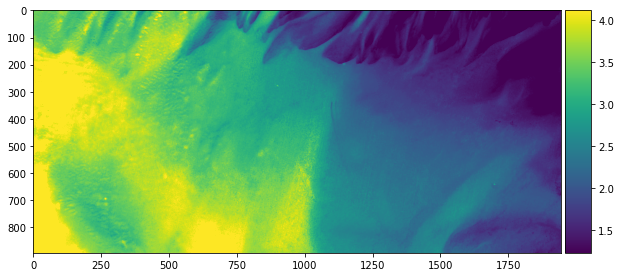

In [18]:
eolx.visualization.plot_ndarray_band(estimated_bathy_tuned_lgbm, cmap='viridis')
plt.show()

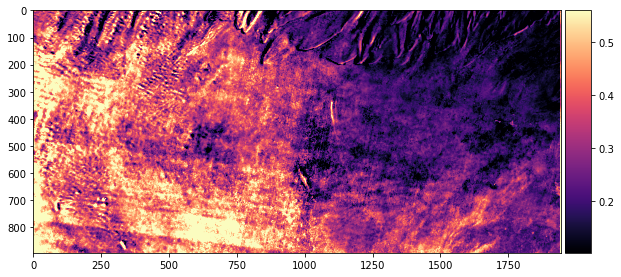

In [19]:
eolx.visualization.plot_ndarray_band(
    np.abs(estimated_bathy_tuned_lgbm - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]),
    cmap='magma'
)
plt.show()

In [20]:
model.save_model('../models/tuned_lgbm_bahamas.txt', num_iteration=model.best_iteration)